In [274]:
import pickle
with open('meta.pickle','rb') as handle:
    meta = pickle.load(handle)
with open('colorindex.pickle','rb') as handle:
    colorindex = pickle.load(handle)
with open('excess.pickle','rb') as handle:
    excess = pickle.load(handle)
with open('temperature.pickle','rb') as handle:
    temperaturemodel = pickle.load(handle)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from ipyevents import Event
from ipywidgets import Label
import numpy as np
import extinction as ext
import seaborn as sns
from scipy.interpolate import interp1d
import math
from scipy.optimize import curve_fit
from scipy.optimize import leastsq

In [140]:
def scoreR2(y,prey):
    y,prey = np.array(y),np.array(prey)
    ybar = mean(y)
    ss_tot = sum((y-ybar)**2)
    ss_res = sum((y-prey)**2)
    return 1. - ss_res/ss_tot

def semilog10x(x,a,b):
    x = np.array(x)
    return a * np.log10(x + 1.) + b

def scale(x,scale):
    x = np.array(x)
    return scale * x

def mag2flux(mag,wave):
    import numpy as np
    mag = np.array(mag)
    wave = np.array(wave)
    return 10**(-0.4*(mag + 2.406 + 5*np.log10(wave)))

def mag2eflux(f,dm):
    import numpy as np
    f = np.array(f)
    dm = np.array(dm)
    return f * np.log(10.) * 0.4 * dm

def linear(x,m,c):
    import numpy as np
    x = np.array(x)
    return m*x + c

def quad(x,a,b,c):
    import numpy as np
    x = np.array(x)
    return a*(x-b)**2 + c

def invquad(x,a,b,c):
    return 1./quad(x,a,b,c)

def power(x,a,b,c):
    import numpy as np
    x = np.array(x)
    return a*(x/b)**c

def expo(x,a,b):
    import numpy as np
    x = np.array(x)
    return a * np.exp(b * x)

def expo2(x,a,b,c):
    import numpy as np
    x = np.array(x)
    return a * np.exp(b*x**2 + c*x)

def planck(wave,temp,scale=1.):
    import numpy as np
    w = np.array(wave) / 1e8 # A to cm
    c1 = 3.7417749e-5 # 2 pi h c c
    c2 = 1.4387687 # h c / k
    val = c2/w/temp
    bbflux = c1 / (w**5 * np.expm1(val))
    return 1e-8 * scale * bbflux # erg/s/cm**2/A

def planckWithBlanket(wave,temp,scale=1.,pow=1.):
    import numpy as np
    wave = np.array(wave)
    trans = wave/4000.
    trans[trans>1.] = 1.
    return planck(wave,temp,scale) * trans**pow

def twoplanck(wave,temp,scale,temp2,scale2):
    return planck(wave,temp,scale) + planck(wave,temp2,scale2)

def temperature2fluxratio(temp,w1,w2):
    return planck(w1,temp)/planck(w2,temp)

def timescalefactor(x,shift,scale):
    # list of x = [stdx,stdy,estdy,mstdy,tarx,tary,etary,shifttary,kind]
    import numpy as np
    stdx,stdy,estdy,mstdy,tarx,tary,etary,shifttary,kind = x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8]
    stdx,stdy,estdy = np.array(stdx),np.array(stdy),np.array(estdy)
    tarx,tary,etary = np.array(tarx),np.array(tary),np.array(etary)
    targx = (tarx+shift)*scale
    tary = tary+shifttary
    tgrid = tarx
    mod = interp1d(stdx,stdy/mstdy,kind)
    emod = interp1d(stdx,estdy,kind='nearest')
    try:
        prey = mod(tgrid)
        eprey = emod(tgrid)
        chisq = (prey - tary)**2 / (estdy**2 + etary**2)
    except:
        print('Exception, cannot interpolate p=[{0:.2E} {1:.2E} {2:.2E}]'.format(shift,scale,shifttary))
        chisq = None

    return chisq

In [42]:
wavelength = {'UVW2': 1928.,
            'UVM2': 2246.,
            'UVW1': 2600.,
            'U': 3571., 'u': 3543.,
            'B': 4344., "B'": 4344.,
            'g': 4770., 'G': 4770.,
            'V': 5456.,
            'R': 6442., 'r': 6231.,
            'I': 7994., 'i': 7625.,
            'J': 12355.,
            'H': 16458.,
            'KS': 21603., "K'": 21603.,
            'I1': 35500.,
            'I2': 44930.,
            'I3': 57310.,
            'I4': 78720.}

# values = mAB - mVega
# Swift calibration (UVW2--V): https://swift.gsfc.nasa.gov/analysis/uvot_digest/zeropts.html
# RI calibration: http://www.astronomy.ohio-state.edu/~martini/usefuldata.html
vega2AB = {'UVW2': 1.73,
          'UVM2': 1.69,
          'UVW1': 1.51,
          'U': 1.02,
          'B': -0.13, "B'": -0.13,
           'g': -0.08, 'G': -0.08,
          'V': -0.01,
          'R': 0.21,
          'I': 0.45,
          'H': 1.39,
          'J': 0.91,
          'KS': 1.85, "K'": 1.85}

In [32]:
# load data
s1 = 'https://api.sne.space/'
s2 = list(meta.keys())
s3 = '/photometry/time+instrument+telescope+model+realization+magnitude+e_magnitude+zeropoint+band+bandset+system+upperlimit?format=csv'
sn = pd.DataFrame()
for i in s2:
    if meta[i]['quality']!=99:
        continue
    x = pd.read_csv(s1+i+s3)
    sn = sn.append(x)

print(sn['event'].unique())
dat = sn.copy()

['SN2008aj' 'SN2014G' 'SN2005db' 'SN2009kn' 'PS15cww' 'SN2010jp' 'SN2005cp'
 'SN2008iy' 'SN1999E' 'SN2005kd' 'SN2010al' 'SN2011hw' 'SN2011iw']


In [49]:
dat = sn.copy()

x = dat.copy()

# exclude IR bands
band = ['J','H','KS','I1','I2','K','z','y','C','Y','Ks','w']
x = x[~x['band'].isin(band)]
x = x[x['band'].notnull()]
x = x[x['upperlimit']!='T']

# exclude bands
key = {'SN2009kn': ["r'","i'","u'"]
      ,'SN2005kd': ['R','I']
      ,'SN2010al': ["u'"]}
for i in key.keys():
    a = x[x['event']==i]
    b = x[x['event']!=i]
    for j in key[i]:
        a = a[a['band']!=j]
    x = a.append(b)
    
# phase
b = None
for i in x['event'].unique():
    a = x[x['event']==i]
    a['phase'] = (a['time'] - meta[i]['maxOptical'])/(1. + meta[i]['redshift'])
    try:
        b = b.append(a)
    except:
        b = a.copy()
x = b.copy()

# vega2AB
b = None
for i in x['band'].unique():
    a = x[x['band']==i]
    if not i in {"r'","i'","u'",'u','r','i'}:
        a['magAB'] = a['magnitude'] + vega2AB[i]
    else:
        a['magAB'] = a['magnitude']
    try:
        b = b.append(a)
    except:
        b = a
x = b.copy()

# change
key = {'SN2008aj': [("r'",'R'),("i'",'I')]
      ,'SN2014G': [('r','R'),('i','I')]
      ,'PS15cww': [('r','R'),('i','I')]
      ,'SN2005kd': [("r'",'R'),("i'",'I')]
      ,'SN2010al': [("i'",'I'),("r'",'R')]}
for i in key.keys():
    a = x[x['event']==i]
    b = x[x['event']!=i]
    for j in key[i]:
        aa = a[a['band']==j[0]]
        aaa = a[a['band']!=j[0]]
        aa['band'] = j[1]
        a = aa.append(aaa)
    x = a.append(b)

# de-reddenning
c = None
for i in x['event'].unique():
    a = x[x['event']==i]
    for j in a['band'].unique():
        b = a[a['band']==j]
        b['magAB'] = b['magAB'] - ext.fm07(np.array([wavelength[j]]), 3.1*meta[i]['ebvGal'])[0]
        try:
            c = c.append(b)
        except:
            c = b.copy()
x = c.copy()  

# choose columns
key = ['event','time','phase','band','magAB','e_magnitude']   
x = x[key].copy()

# # filter phase
# key = {'SN2009ip': (-12,100)
#       ,'SN2011ht': (-50,100)
#       ,'SN2007pk': (-50,100)
#       ,'PTF11iqb': (-50,100)
#       ,'SN2013fs': (-50,100)
#       ,'SN2006aa': (-30,30)
#       ,'SN2008ip': (-50,100)
#       ,'SN1998S': (-50,100)
#       ,'SN1994Y': (-50,100)
#       ,'SN2015bh': (-50,100)
#       ,'SN2009kr': (-50,100)}
# b = None
# for i in key.keys():
#     a = x[x['event']==i]
#     a = a[a['phase']>=key[i][0]]
#     a = a[a['phase']<=key[i][1]]
#     try:
#         b = b.append(a)
#     except:
#         b = a.copy()
# x = b.copy()

dat = x.copy()

C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

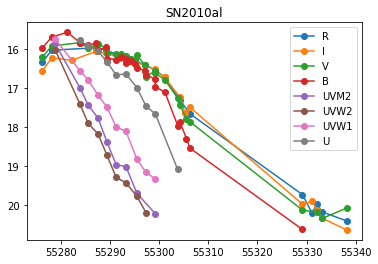

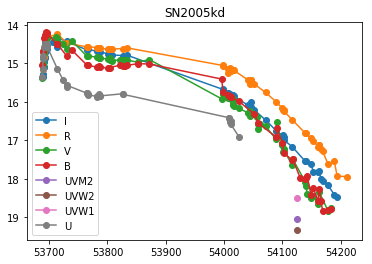

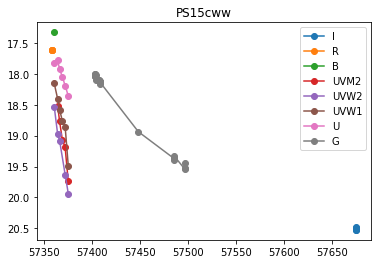

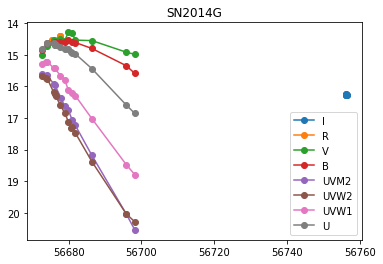

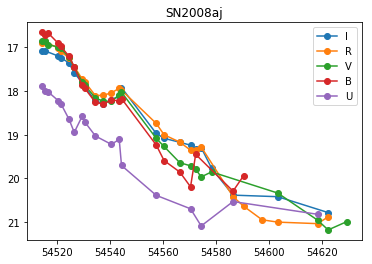

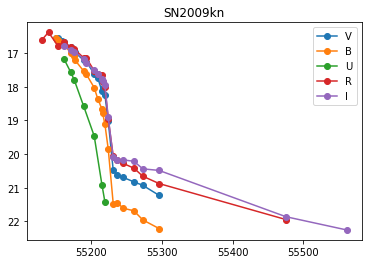

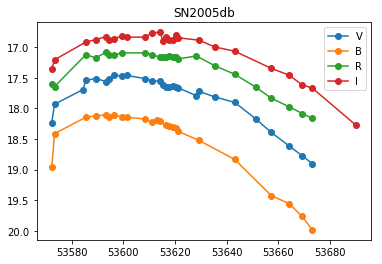

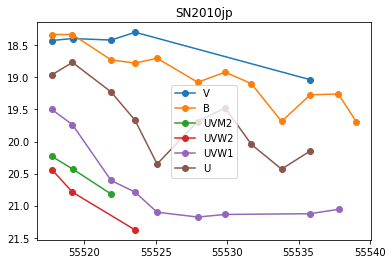

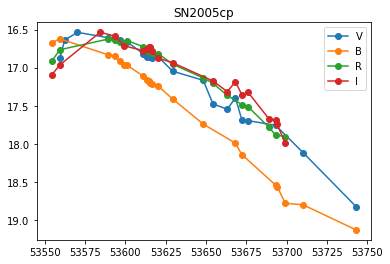

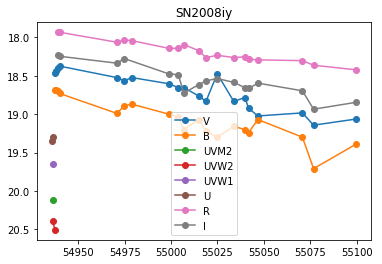

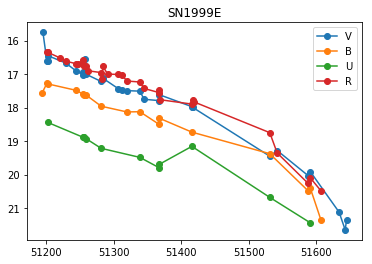

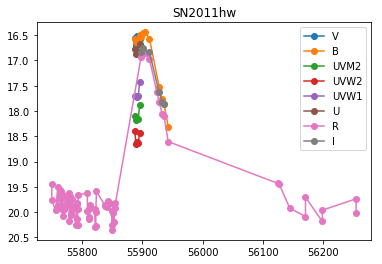

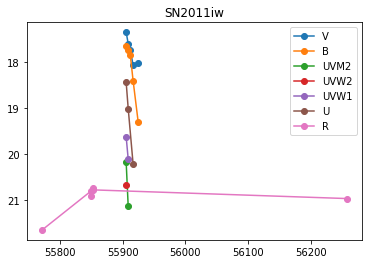

In [52]:
for i in dat['event'].unique():
    x = dat[dat['event']==i]
    plt.figure()
    for j in x['band'].unique():
        y = x[x['band']==j]
        plt.plot(y['time'],y['magAB'],marker='o',label=j)
    plt.title(i)
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

# Predict phase 0 and redshift from color indices

In [96]:
def findshift(x,shift):
    #x[0] = data, x[1] = popt, x[2] = redshift
    a = (x[0] - shift)/(1.+x[2])
    y = expo(a,*x[1])
    return y

def findshiftNredsfhit(x,shift,redshift):
    a = (x[0] - shift)/(1.+redshift)
    y = expo(a,*x[1])
    return y

In [ ]:
interpolModel = {}
for j in dat['event'].unique():
    a = dat[dat['event']==j]
    for i in a['band'].unique():
        x = a[a['band']==i]
        interpolModel[(j,i)] = {}
        try:
            interpolModel[(j,i)]['magAB'] = interp1d(x['time'],x['magAB'],kind='nearest')
            interpolModel[(j,i)]['e_magnitude'] = interp1d(x['time'],x['e_magnitude'],kind='nearest')
            interpolModel[(j,i)]['trange'] = (math.ceil(min(x['time'])),math.floor(max(x['time']))+1)

            plt.figure()
            plt.plot(x['time'],x['magAB'],'k.',label=i)
            tgrid = np.arange(interpolModel[(j,i)]['trange'][0],interpolModel[(j,i)]['trange'][1],step=1)
            plt.errorbar(tgrid
                         ,interpolModel[(j,i)]['magAB'](tgrid)
                         ,interpolModel[(j,i)]['e_magnitude'](tgrid))
            plt.gca().invert_yaxis()
            plt.title(j)
            plt.legend()
            plt.show()
        except:
            print('Exception {0} {1}'.format(i,j))

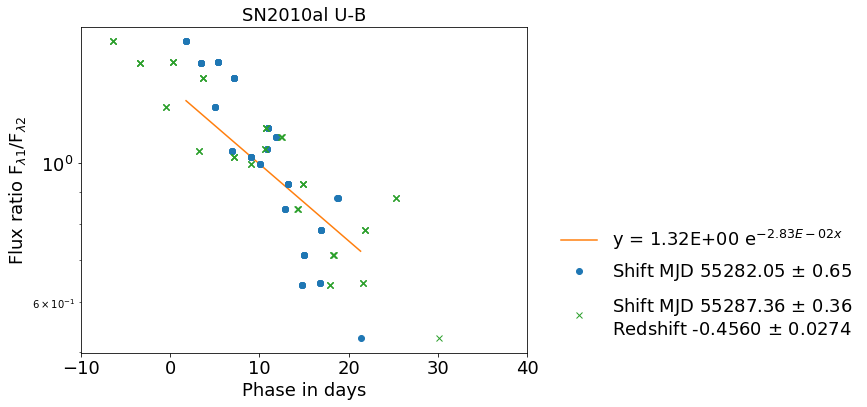

SN2010al 
maxOptical MJD 55283.88
Redshift 0.017155


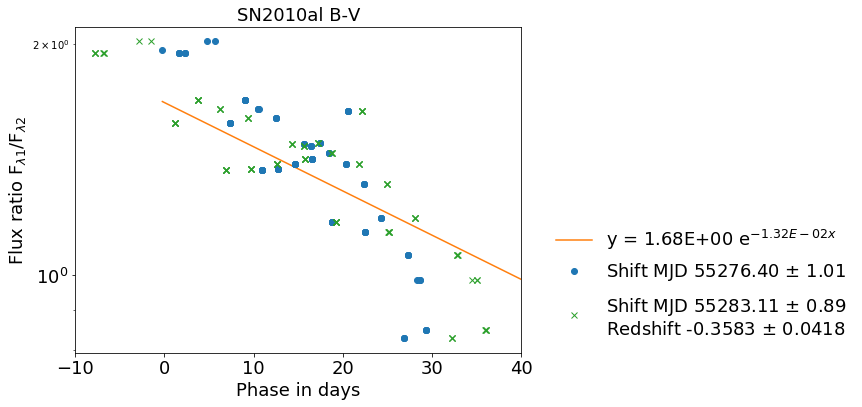

SN2010al 
maxOptical MJD 55283.88
Redshift 0.017155


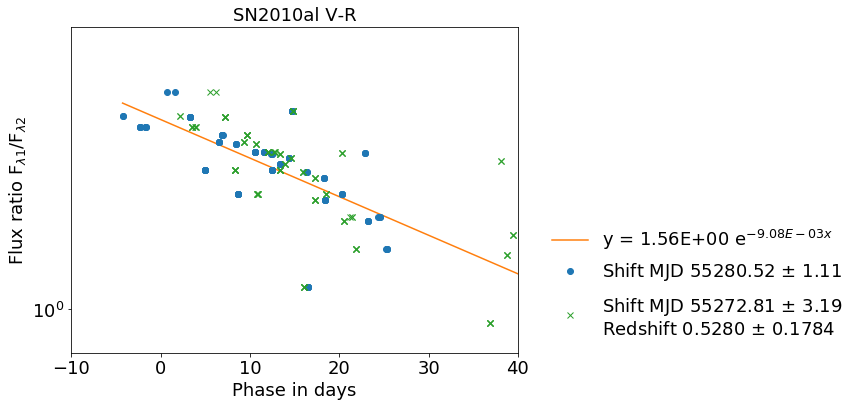

SN2010al 
maxOptical MJD 55283.88
Redshift 0.017155


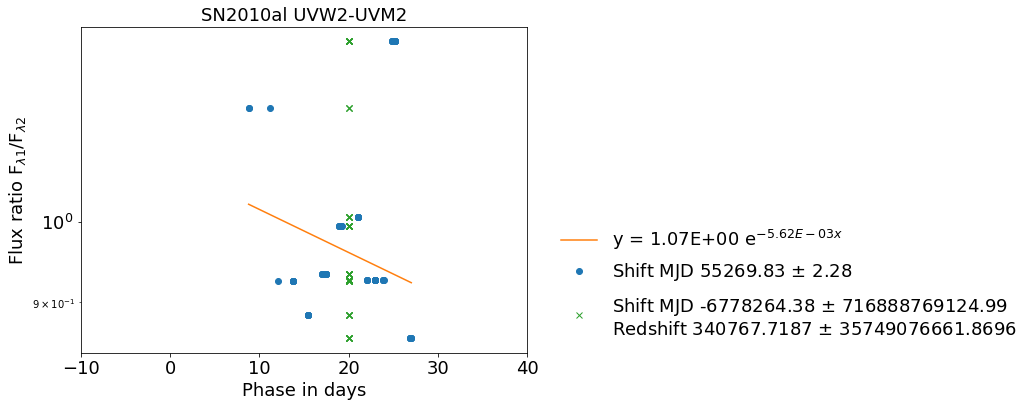

SN2010al 
maxOptical MJD 55283.88
Redshift 0.017155


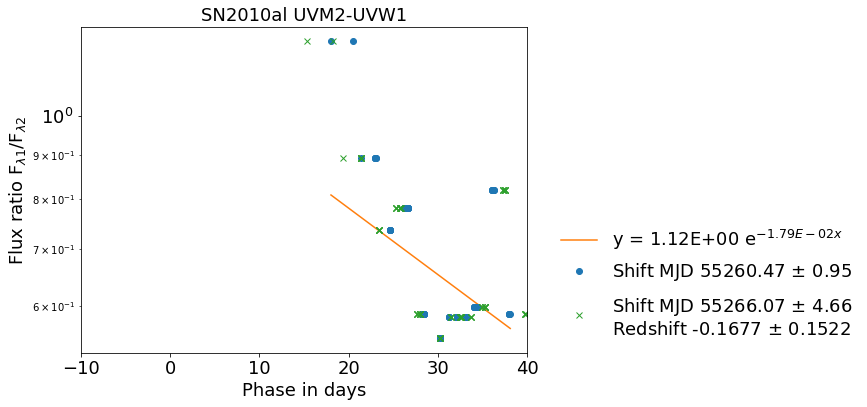

SN2010al 
maxOptical MJD 55283.88
Redshift 0.017155


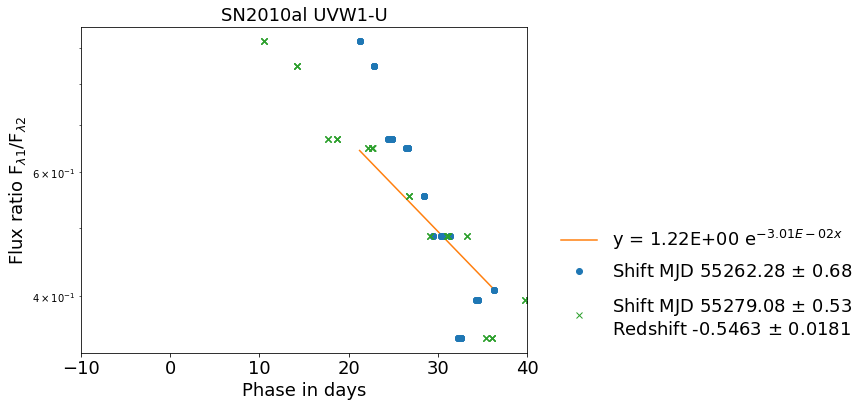

SN2010al 
maxOptical MJD 55283.88
Redshift 0.017155


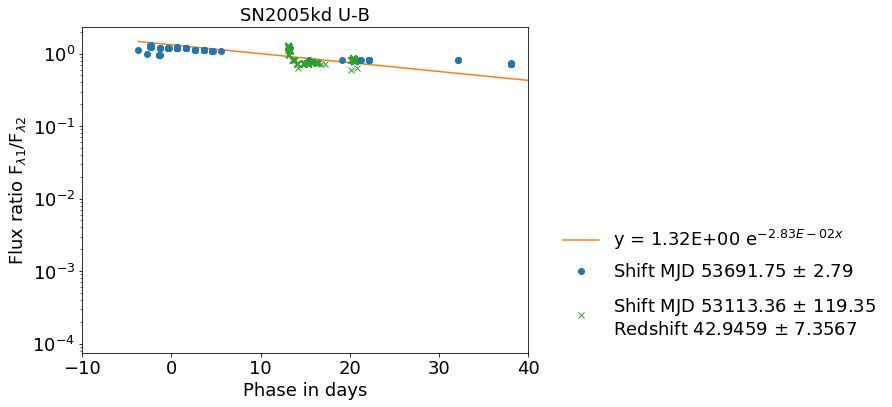

SN2005kd 
maxOptical MJD 53711.19
Redshift 0.01504


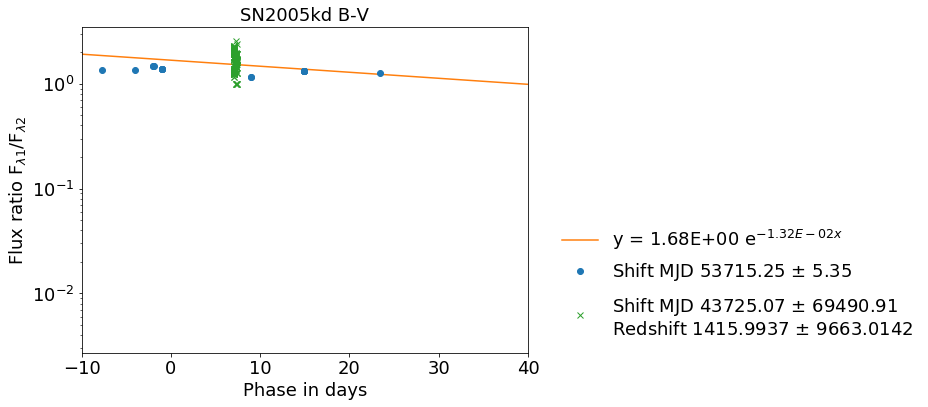

SN2005kd 
maxOptical MJD 53711.19
Redshift 0.01504


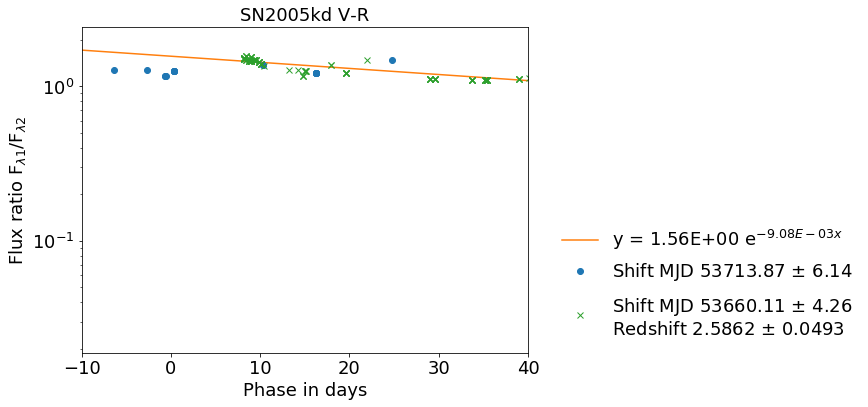

SN2005kd 
maxOptical MJD 53711.19
Redshift 0.01504
fail
fail
fail
fail
fail
fail


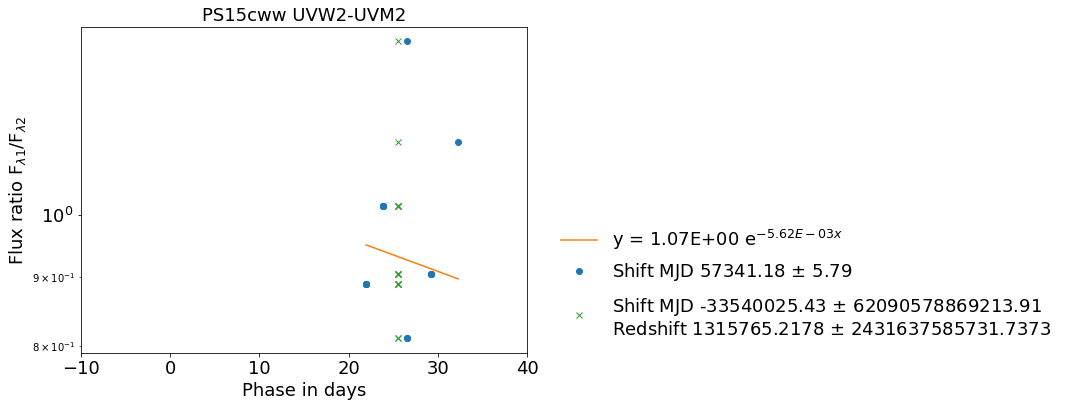

PS15cww 
maxOptical MJD 57361.42
Redshift 0.063


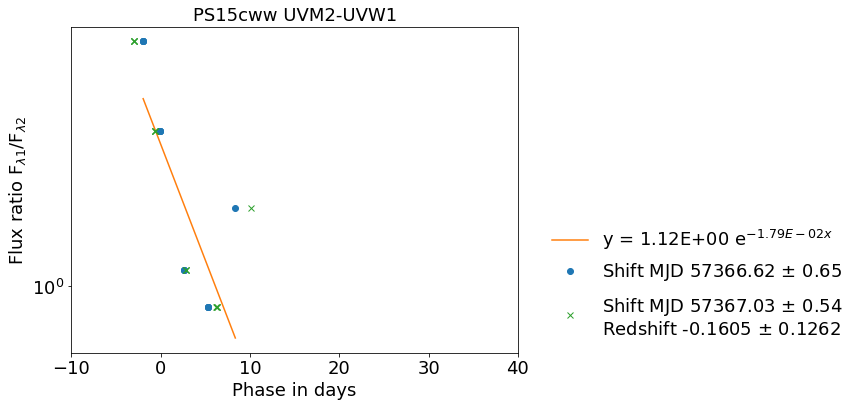

PS15cww 
maxOptical MJD 57361.42
Redshift 0.063


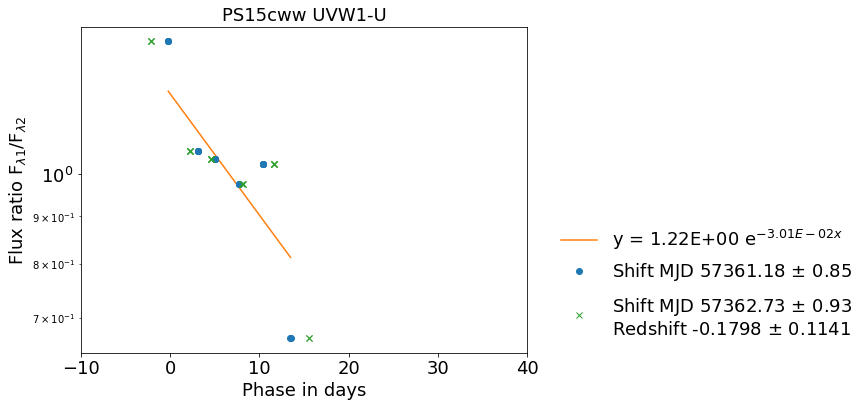

PS15cww 
maxOptical MJD 57361.42
Redshift 0.063


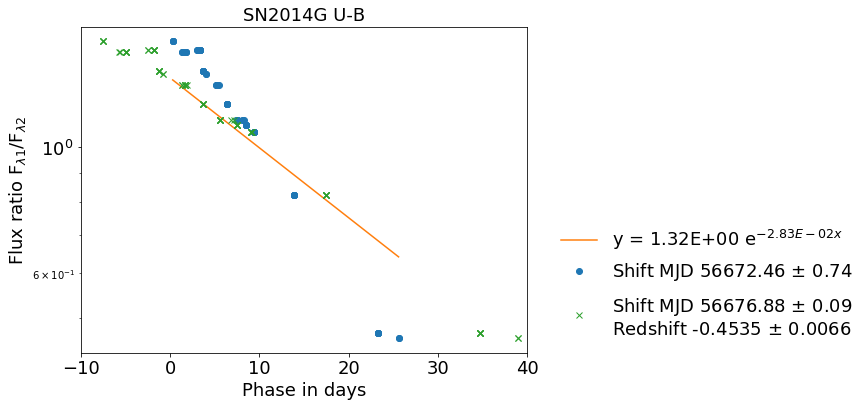

SN2014G 
maxOptical MJD 56679.97
Redshift 0.004503


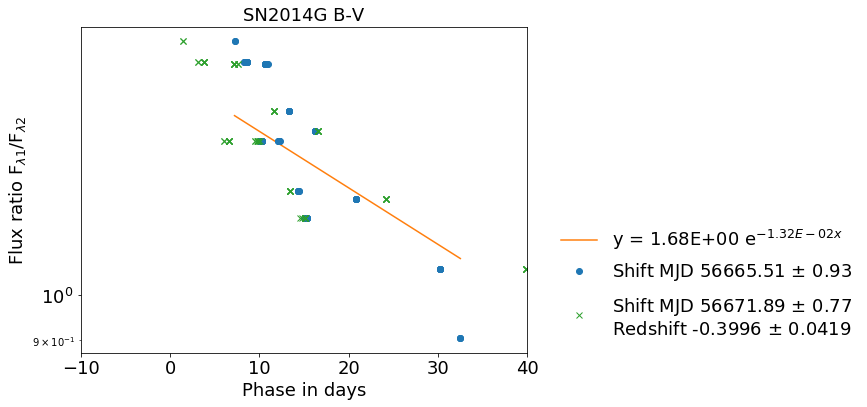

SN2014G 
maxOptical MJD 56679.97
Redshift 0.004503


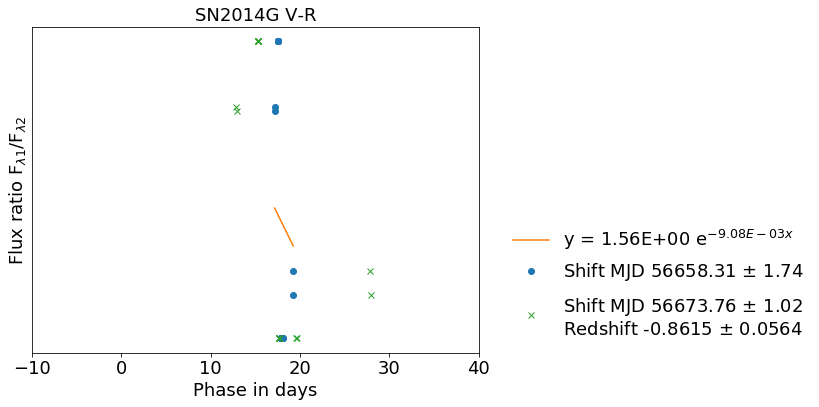

SN2014G 
maxOptical MJD 56679.97
Redshift 0.004503


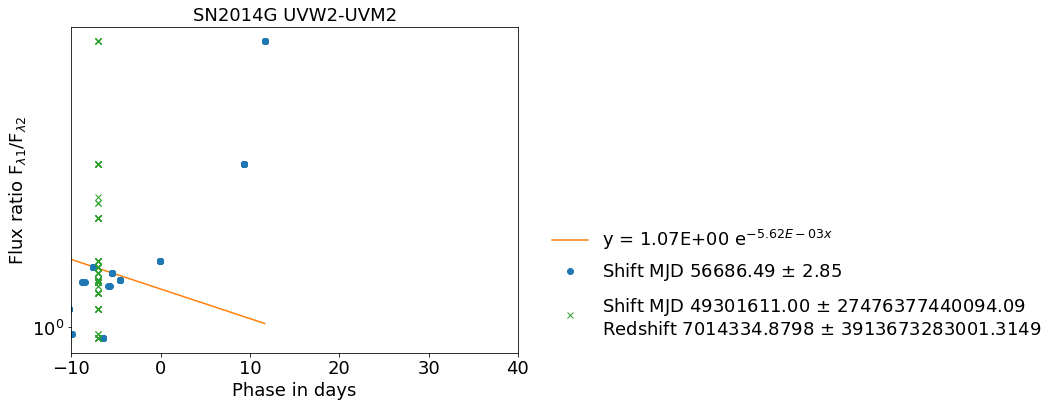

SN2014G 
maxOptical MJD 56679.97
Redshift 0.004503


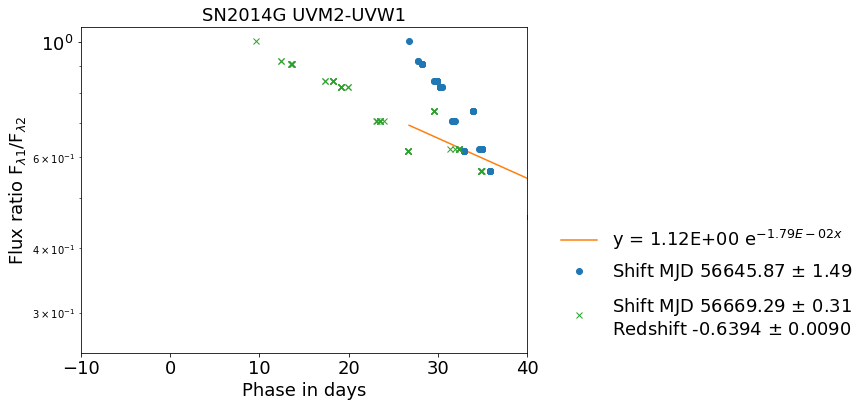

SN2014G 
maxOptical MJD 56679.97
Redshift 0.004503


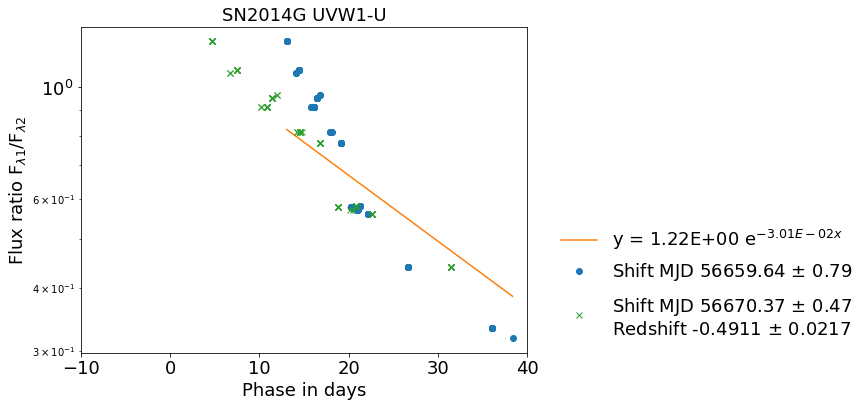

SN2014G 
maxOptical MJD 56679.97
Redshift 0.004503


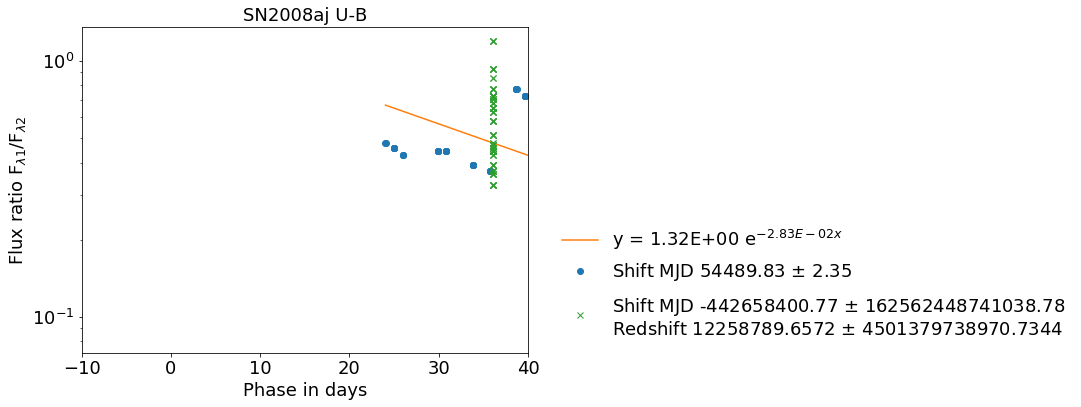

SN2008aj 
maxOptical MJD 54515.4
Redshift 0.025


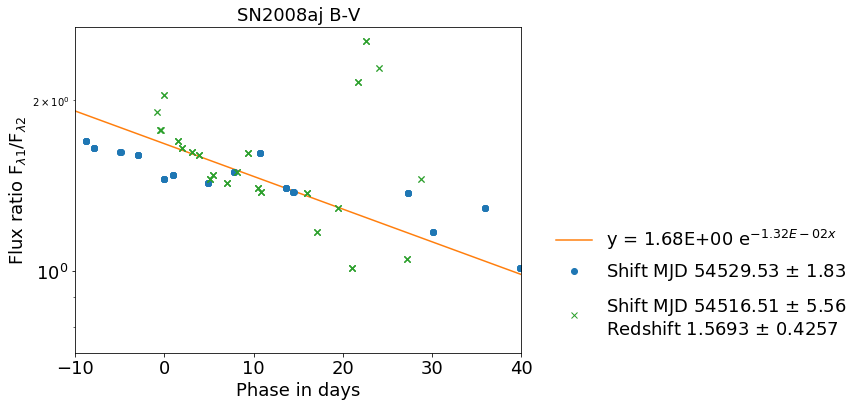

SN2008aj 
maxOptical MJD 54515.4
Redshift 0.025


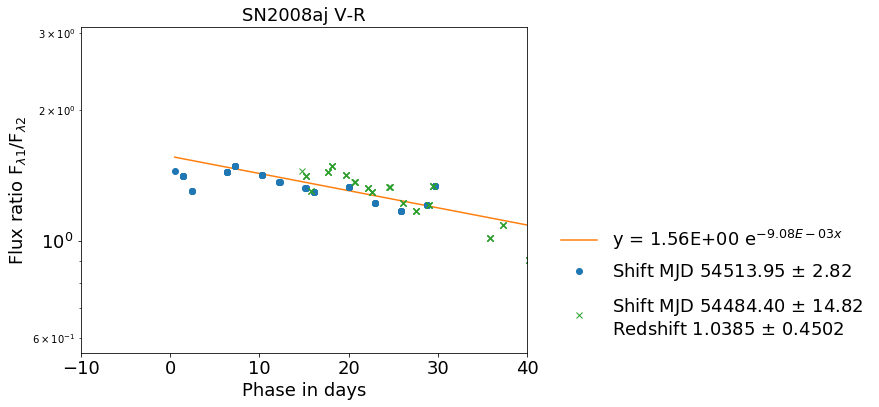

SN2008aj 
maxOptical MJD 54515.4
Redshift 0.025
fail
fail
fail


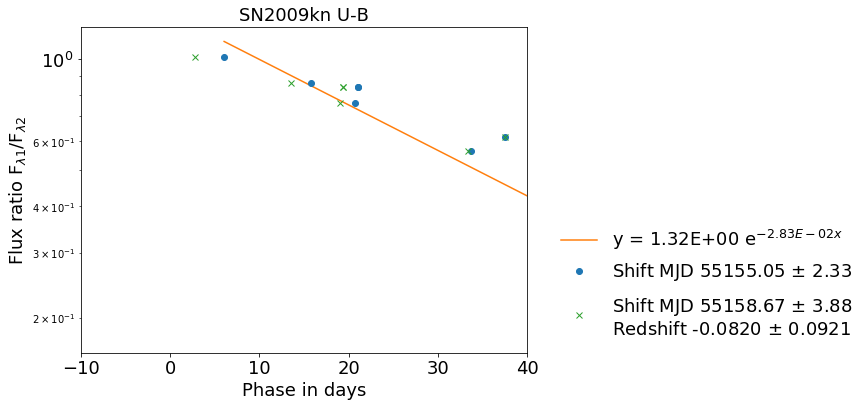

SN2009kn 
maxOptical MJD 55153.5
Redshift 0.0143


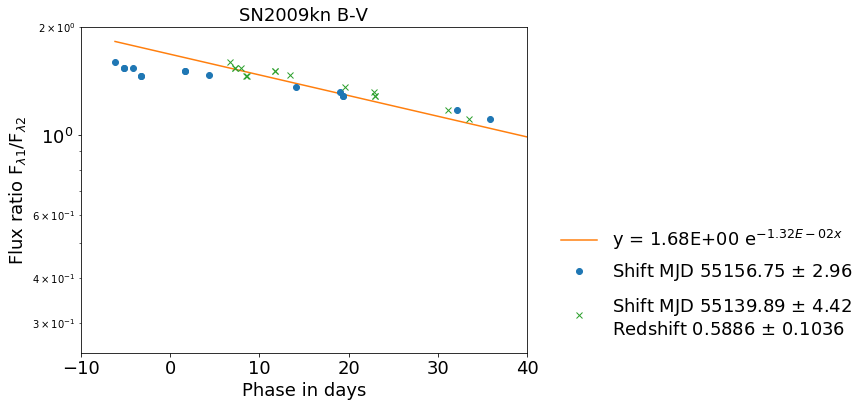

SN2009kn 
maxOptical MJD 55153.5
Redshift 0.0143


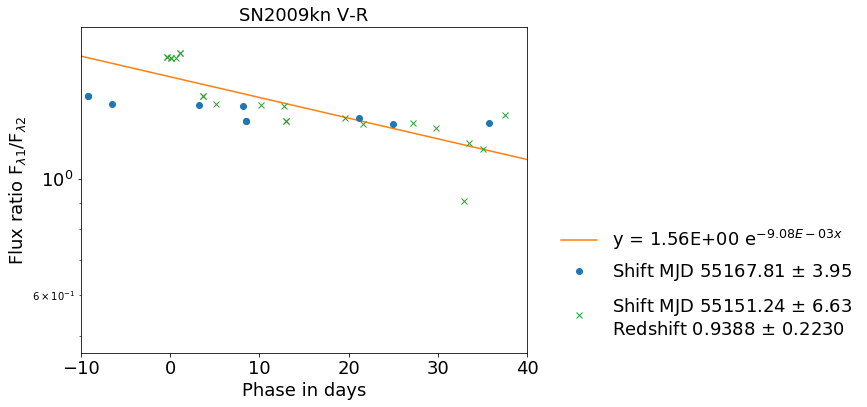

SN2009kn 
maxOptical MJD 55153.5
Redshift 0.0143
fail
fail
fail
fail


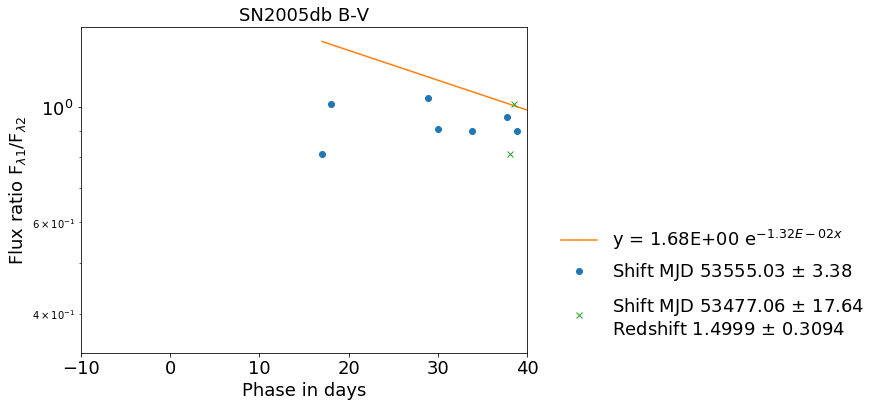

SN2005db 
maxOptical MJD 53596.39
Redshift 0.015124


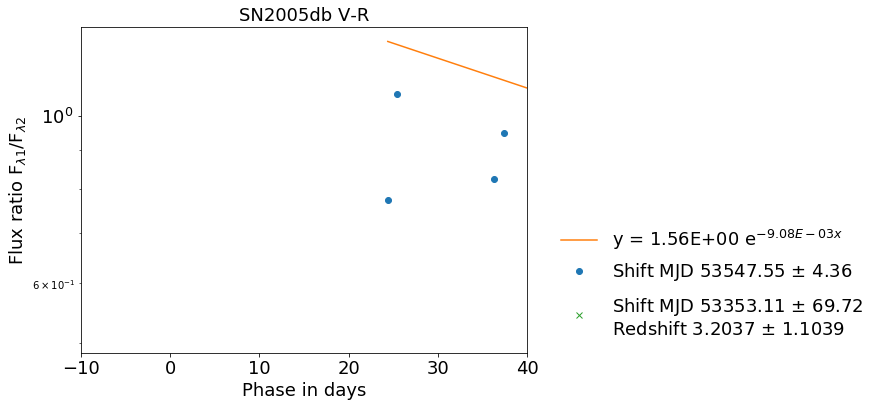

SN2005db 
maxOptical MJD 53596.39
Redshift 0.015124
fail
fail
fail


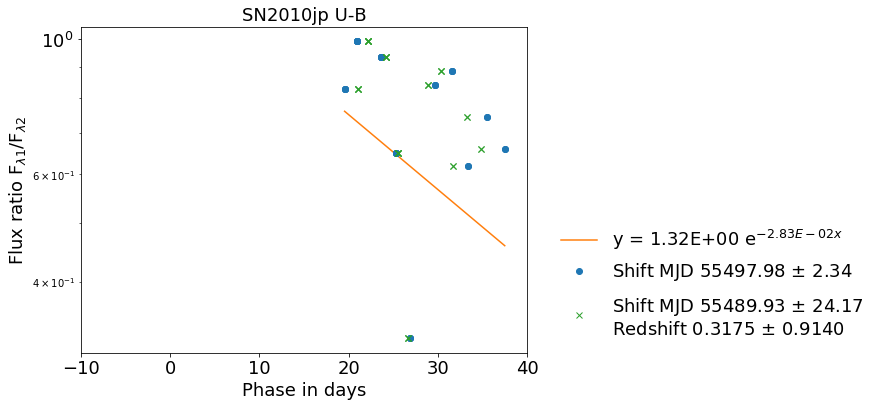

SN2010jp 
maxOptical MJD 55519.16
Redshift 0.0092


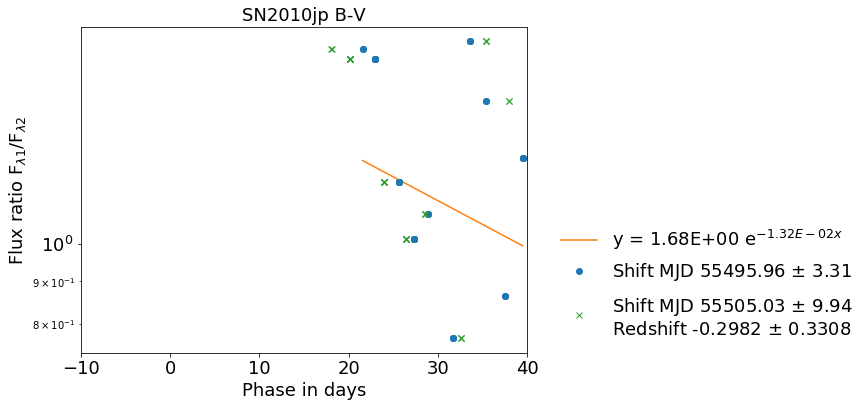

SN2010jp 
maxOptical MJD 55519.16
Redshift 0.0092
fail


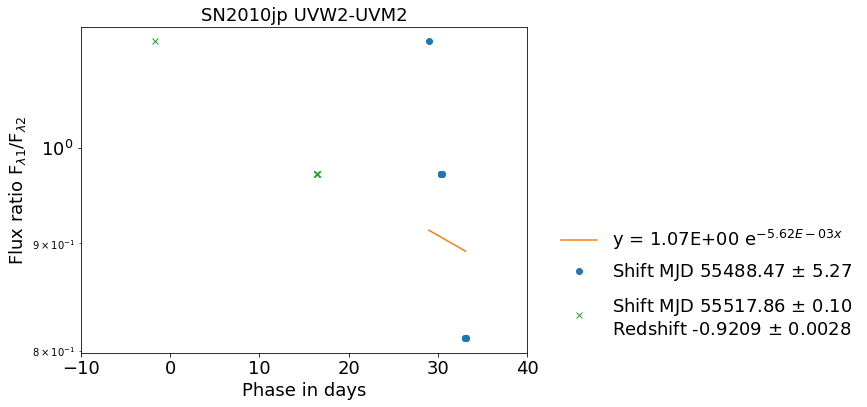

SN2010jp 
maxOptical MJD 55519.16
Redshift 0.0092


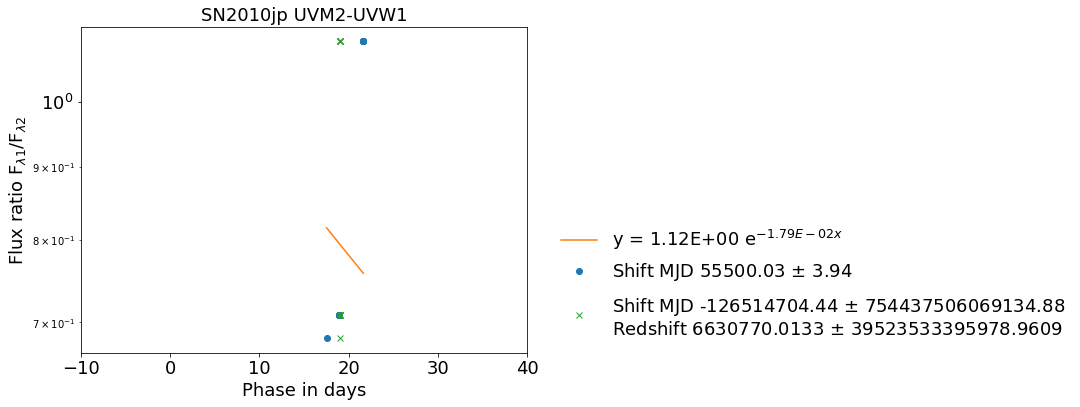

SN2010jp 
maxOptical MJD 55519.16
Redshift 0.0092


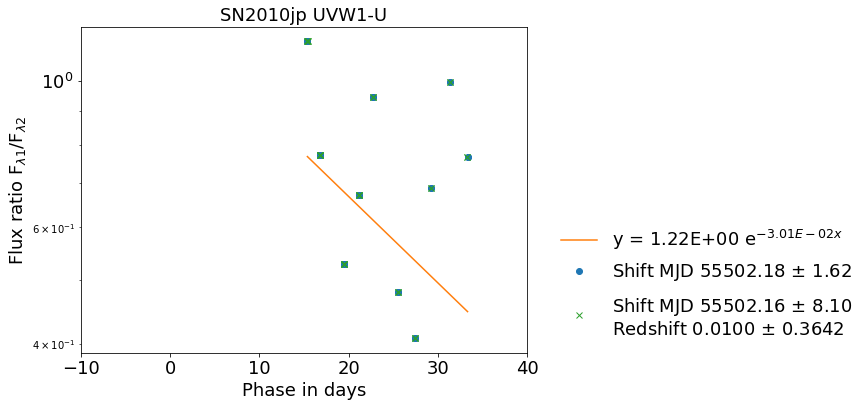

SN2010jp 
maxOptical MJD 55519.16
Redshift 0.0092
fail


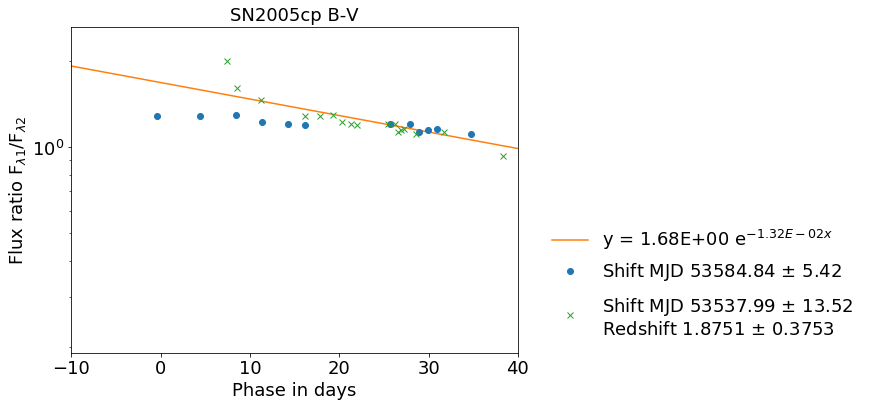

SN2005cp 
maxOptical MJD 53570.35
Redshift 0.022115


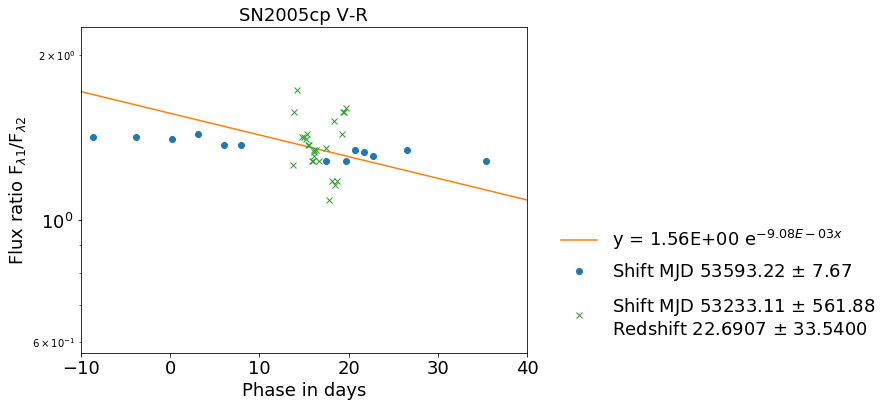

SN2005cp 
maxOptical MJD 53570.35
Redshift 0.022115
fail
fail
fail
fail


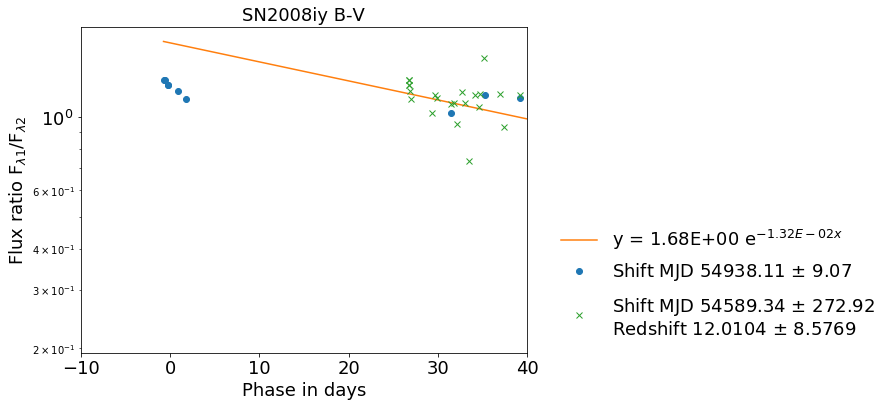

SN2008iy 
maxOptical MJD 54939.96
Redshift 0.041


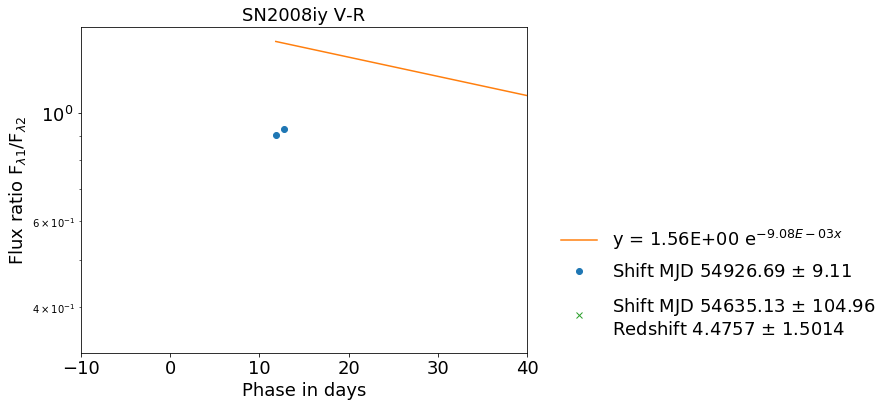

SN2008iy 
maxOptical MJD 54939.96
Redshift 0.041
fail
fail
fail
fail
fail
fail
fail
fail
fail


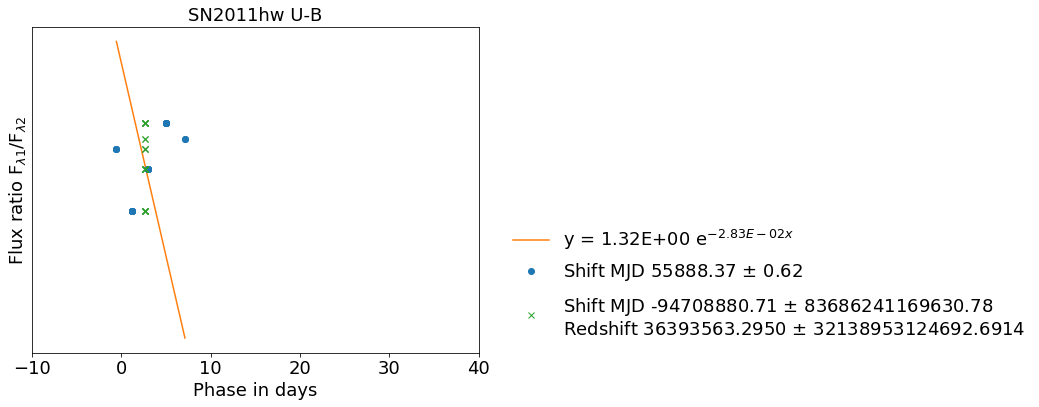

SN2011hw 
maxOptical MJD 55891.4
Redshift 0.023


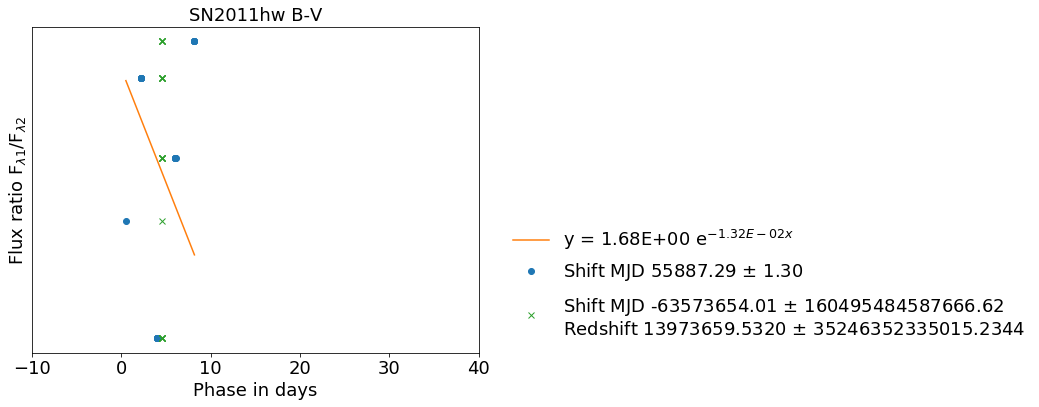

SN2011hw 
maxOptical MJD 55891.4
Redshift 0.023


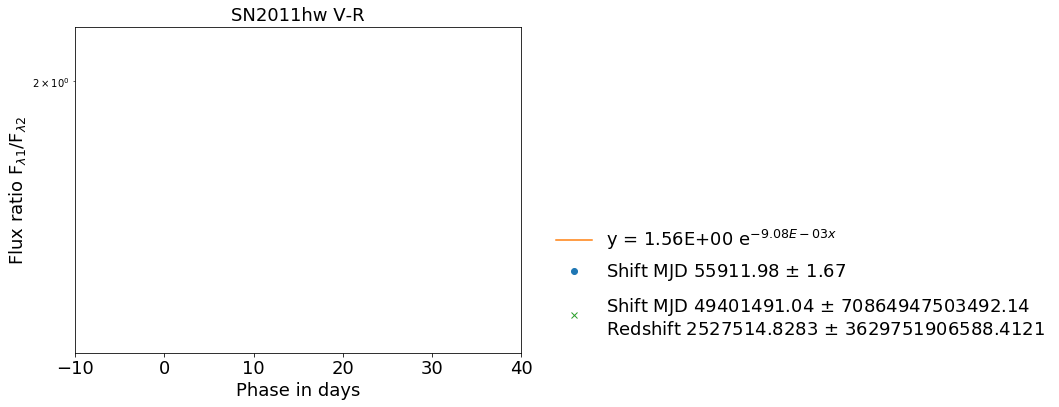

SN2011hw 
maxOptical MJD 55891.4
Redshift 0.023


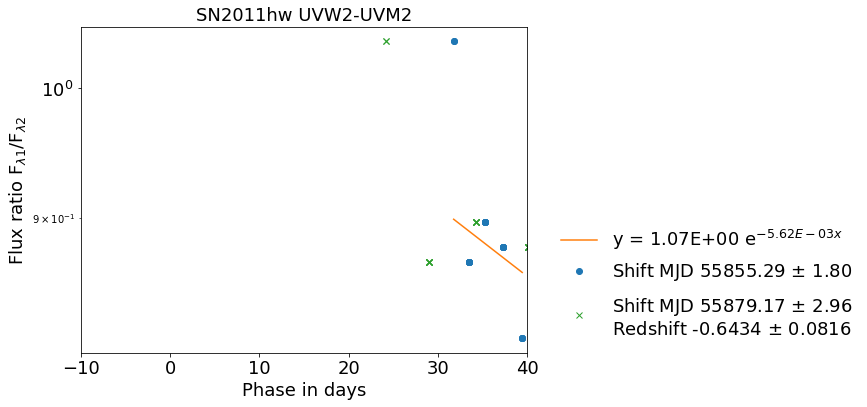

SN2011hw 
maxOptical MJD 55891.4
Redshift 0.023


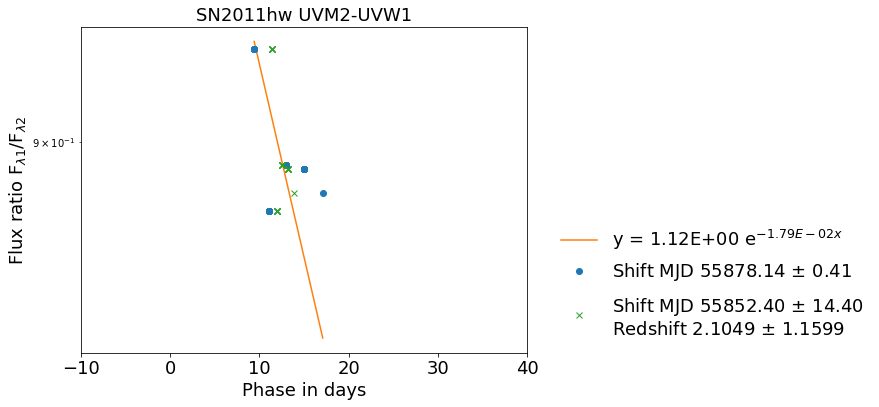

SN2011hw 
maxOptical MJD 55891.4
Redshift 0.023


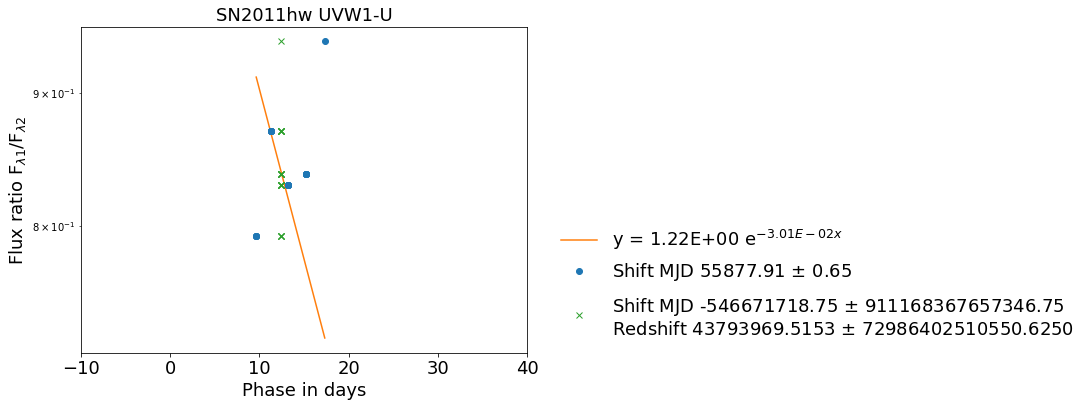

SN2011hw 
maxOptical MJD 55891.4
Redshift 0.023


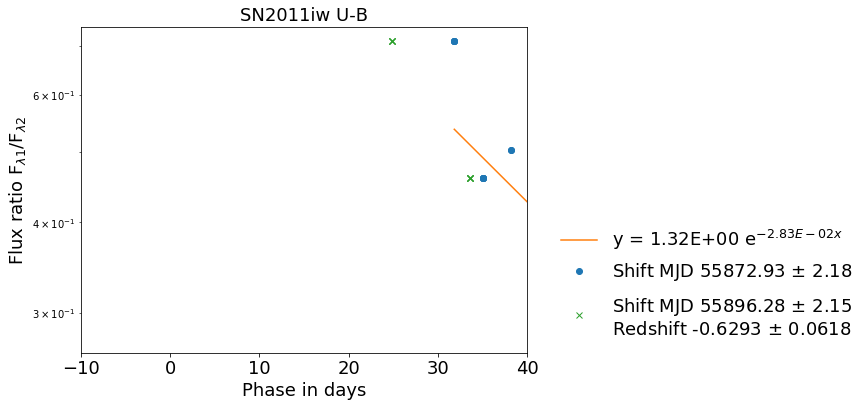

SN2011iw 
maxOptical MJD 55905.51
Redshift 0.023


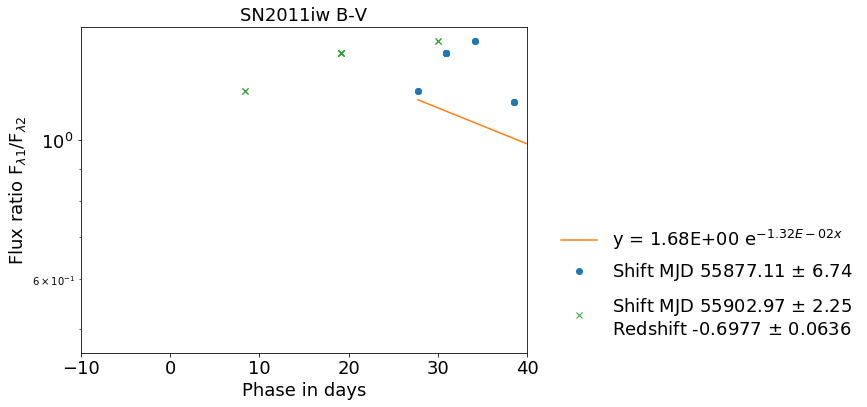

SN2011iw 
maxOptical MJD 55905.51
Redshift 0.023


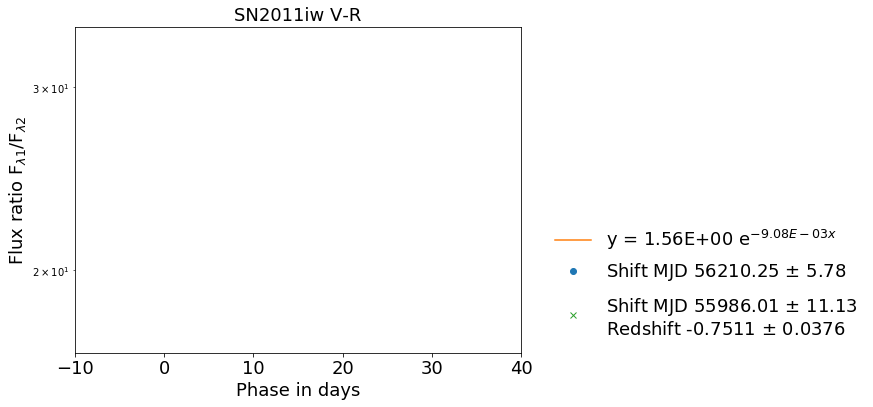

SN2011iw 
maxOptical MJD 55905.51
Redshift 0.023
fail


C:\Users\Kornpob\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


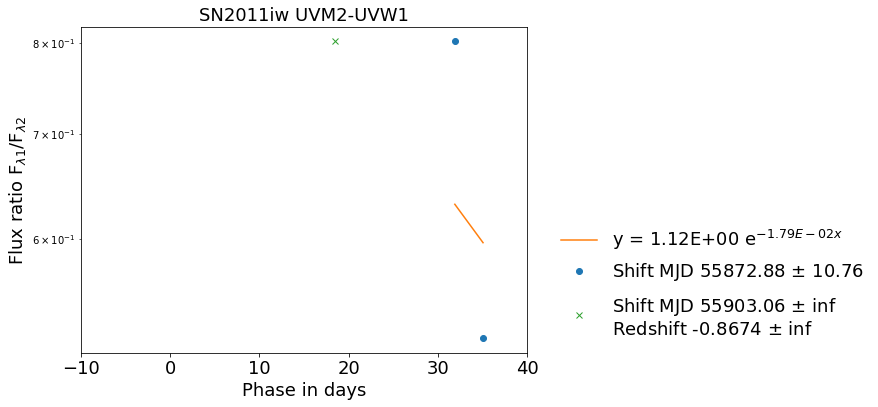

SN2011iw 
maxOptical MJD 55905.51
Redshift 0.023


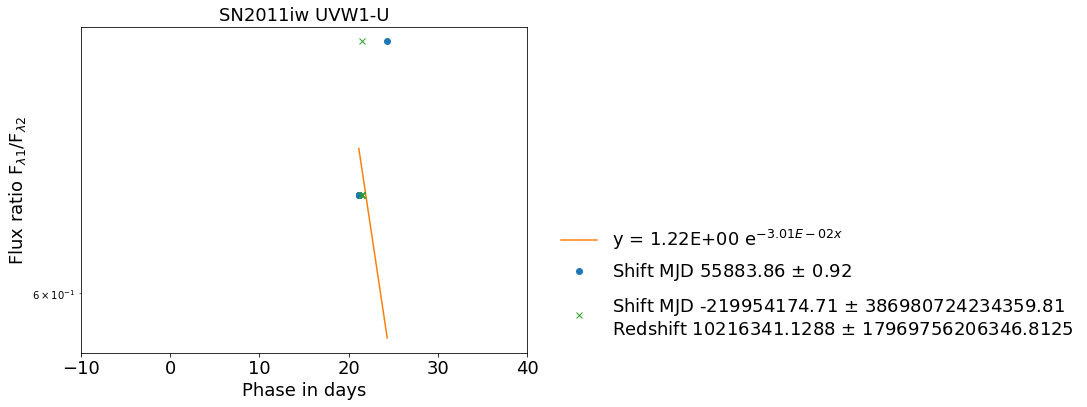

SN2011iw 
maxOptical MJD 55905.51
Redshift 0.023


In [270]:
colorpair = [('U','B'),('B','V'),('V','R'),('UVW2','UVM2'),('UVM2','UVW1'),('UVW1','U')]
prediction = {}
for i in dat['event'].unique():
    prediction[i] = {}
    x = dat[dat['event']==i]
    
    # time grid
    tgrid = x['time'].unique()
    index = np.argsort(tgrid)
    tgrid = tgrid[index]
    
    # color index
    for j in colorpair:
        prediction[i][('colorindex',j[0],j[1])] = {}
        m1,em1,m2,em2,tt = [],[],[],[],[]
        for k in tgrid:
            try:
                a = mag2flux(interpolModel[(i,j[0])]['magAB'](k),wavelength[j[0]])
                ea = mag2eflux(a,interpolModel[(i,j[0])]['e_magnitude'](k))
                b = mag2flux(interpolModel[(i,j[1])]['magAB'](k),wavelength[j[1]])
                eb = mag2eflux(b,interpolModel[(i,j[1])]['e_magnitude'](k))
            except:
                continue
            m1.append(a),em1.append(ea),m2.append(b),em2.append(b),tt.append(k)
            
        r = np.array(m1)/np.array(m2)
        er = np.sqrt((np.array(em1)/np.array(m2))**2 + ((np.array(m1)/np.array(m2))*(np.array(em2)/np.array(m2)))**2)
#         plt.errorbar(tt,r,marker='o',linestyle='',label=j)

        # Given redshift, find peak
        try:
            popt,pcov = colorindex[('expo',j[0],j[1])][0],colorindex[('expo',j[0],j[1])][1]
            tt,r,er = np.array(tt),np.array(r),np.array(er)
            pp,pc = curve_fit(findshift,[tt,popt,meta[i]['redshift']],r,sigma=er,p0=[min(tt)])
            prediction[i][('colorindex',j[0],j[1])]['findshift'] = (pp,pc)
            ttt = (tt-pp[0])/(1.+meta[i]['redshift'])
            plt.figure(figsize=(8,6))
            plt.errorbar(ttt,r,marker='o',linestyle='',label='Shift MJD {0:.2f} $\\pm$ {1:.2f}'.format(pp[0],np.sqrt(pc[0,0])))
            plt.plot(ttt,expo(ttt,*popt),label='y = {0:.2E} e$^{{{1:.2E}x}}$'.format(popt[0],popt[1]))
        except:
            print('fail')
            continue
        
        # find both peak and redshift
        try:
            pp2,pc2 = curve_fit(findshiftNredsfhit,[tt,popt],r,sigma=er,p0=[min(tt),0.01])
            prediction[i][('colorindex',j[0],j[1])]['findshiftNredshift'] = (pp2,pc2)
            ttt = (tt-pp2[0])/(1.+pp2[1])
            plt.errorbar(ttt,r,marker='x',linestyle=''
                         ,label='Shift MJD {0:.2f} $\\pm$ {1:.2f} \nRedshift {2:.4f} $\\pm$ {3:.4f}'.
                         format(pp2[0],np.sqrt(pc2[0,0]),pp2[1],np.sqrt(pc2[1,1]))
                        )
        except:
            pass

        plt.xlim(-10,40)
        plt.yscale('log')
        plt.xticks(fontsize=18)
        plt.xlabel('Phase in days',fontsize=18)
        plt.yticks(fontsize=18)
        plt.ylabel('Flux ratio F$_{\lambda1}$/F$_{\lambda2}$',fontsize=18)
        plt.title('{0} {1}-{2}'.format(i,j[0],j[1]),fontsize=18)
        lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
        
        if i=='SN2010al' and j[0]=='U' and j[1]=='B':
            plt.savefig(r'D:\Model_SED_IIn\plot_80_corlorindex_predict_'+j[0]+'_'+j[1]+'_'+i+'.eps', format='eps', figsize=(16,12), dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

        plt.show()
        
        print('{0} \nmaxOptical MJD {1}\nRedshift {2}'.format(i,meta[i]['maxOptical'],meta[i]['redshift']))   

In [271]:
pd.DataFrame(prediction)

SN2010al  \
colorindex B    V     {'findshift': ([55276.4010963], [[ 1.01480842]...   
           U    B     {'findshift': ([55282.0459176], [[ 0.42669923]...   
           UVM2 UVW1  {'findshift': ([55260.4662695], [[ 0.89597687]...   
           UVW1 U     {'findshift': ([55262.2754246], [[ 0.46608609]...   
           UVW2 UVM2  {'findshift': ([55269.8339578], [[ 5.19981166]...   
           V    R     {'findshift': ([55280.5215645], [[ 1.22616157]...   

                                                               SN2005kd  \
colorindex B    V     {'findshift': ([53715.2460036], [[ 28.65205229...   
           U    B     {'findshift': ([53691.7459319], [[ 7.79384993]...   
           UVM2 UVW1                                                 {}   
           UVW1 U                                                    {}   
           UVW2 UVM2                                                 {}   
           V    R     {'findshift': ([53713.869211], [[ 37.7213004]]...   

                                                                PS15cww  \
colorindex B    V                                                    {}   
           U    B                                                    {}   
           UVM2 UVW1  {'findshift': ([57366.6159875], [[ 0.41785997]...   
           UVW1 U     {'findshift': ([57361.1799113], [[ 0.71403295]...   
           UVW2 UVM2  {'findshift': ([57341.1798182], [[ 33.48155258...   
           V    R                                                    {}   

                                                                SN2014G  \
colorindex B    V     {'findshift': ([56665.5076146], [[ 0.86133987]...   
           U    B     {'findshift': ([56672.456837], [[ 0.54651961]]...   
           UVM2 UVW1  {'findshift': ([56645.8708448], [[ 2.23054896]...   
           UVW1 U     {'findshift': ([56659.6359924], [[ 0.61803278]...   
           UVW2 UVM2  {'findshift': ([56686.4888757], [[ 8.13904928]...   
           V    R     {'findshift': ([56658.3083331], [[ 3.02686642]...   

                                                               SN2008aj  \
colorindex B    V     {'findshift': ([54529.5297091], [[ 3.3416793]]...   
           U    B     {'findshift': ([54489.8310944], [[ 5.53731656]...   
           UVM2 UVW1                                                 {}   
           UVW1 U                                                    {}   
           UVW2 UVM2                                                 {}   
           V    R     {'findshift': ([54513.9528635], [[ 7.94927306]...   

                                                               SN2009kn  \
colorindex B    V     {'findshift': ([55156.7480428], [[ 8.73525938]...   
           U    B     {'findshift': ([55155.0510501], [[ 5.44002928]...   
           UVM2 UVW1                                                 {}   
           UVW1 U                                                    {}   
           UVW2 UVM2                                                 {}   
           V    R     {'findshift': ([55167.8084172], [[ 15.5654046]...   

                                                               SN2005db  \
colorindex B    V     {'findshift': ([53555.0261591], [[ 11.45207558...   
           U    B                                                    {}   
           UVM2 UVW1                                                 {}   
           UVW1 U                                                    {}   
           UVW2 UVM2                                                 {}   
           V    R     {'findshift': ([53547.5469104], [[ 19.05248988...   

                                                               SN2010jp  \
colorindex B    V     {'findshift': ([55495.9587304], [[ 10.96735182...   
           U    B     {'findshift': ([55497.9772742], [[ 5.47399782]...   
           UVM2 UVW1  {'findshift': ([55500.0300432], [[ 15.52290116...   
           UVW1 U     {'findshift': ([55502.1803083], [[ 2.62870492]...   
      

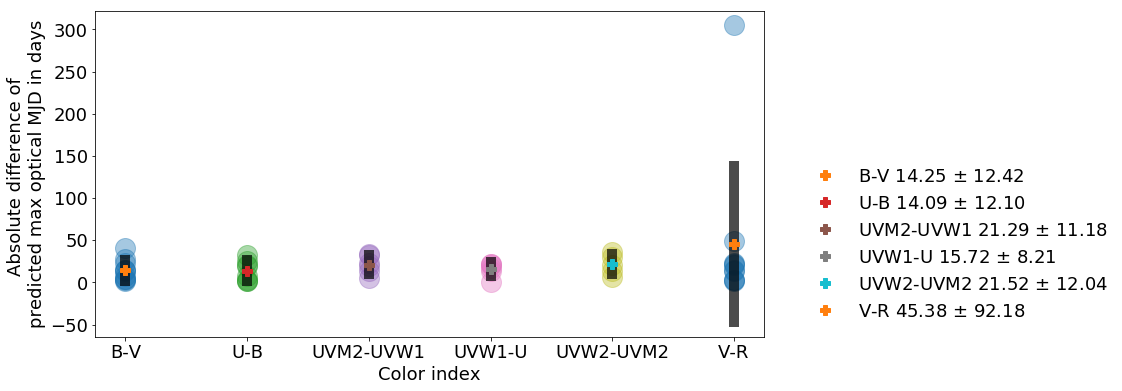

In [273]:
keep = {}
for i in prediction.keys():
    keep[i] = {}
    
for j in colorpair:
    for i in prediction.keys():       
        try:
            keep[i][('colorindex',j[0],j[1])] = np.absolute(prediction[i][('colorindex',j[0],j[1])]['findshift'][0][0] 
                                                            - meta[i]['maxOptical']
                                                           )
        except:
            pass

keep = pd.DataFrame(keep)
keep.reset_index(drop=False,inplace=True)

x = {}
plt.figure(figsize=(12,6))
for i in keep.index:
    str = keep.iloc[i][1:3].values[0] + '-' + keep.iloc[i][1:3].values[1]
    mean = keep.iloc[i][3:].mean()
    std = keep.iloc[i][3:].std()
    plt.plot([str]*len(keep.iloc[i][3:]), keep.iloc[i][3:].values,alpha=0.4,marker = 'o',linestyle='',markersize=20)
    plt.plot([str]*2,[mean-std , mean+std], marker='',linestyle='-',color='black',alpha=0.7,markersize=20,linewidth=10)
    plt.plot([str], keep.iloc[i][3:].mean(),marker = 'P',linestyle='',markersize=10,linewidth=20
             ,label='{0} {1:.2f} $\\pm$ {2:.2f}'.format(str,mean,std))
plt.xticks(fontsize=18)
plt.xlabel('Color index',fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Absolute difference of \npredicted max optical MJD in days',fontsize=18)
lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
plt.savefig(r'D:\Model_SED_IIn\plot_80_phase.eps', format='eps', figsize=(16,12), dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Temperature prediction

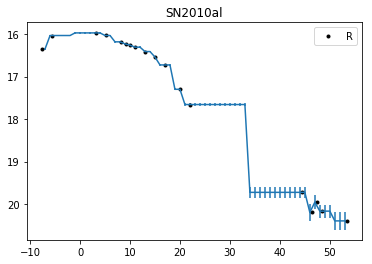

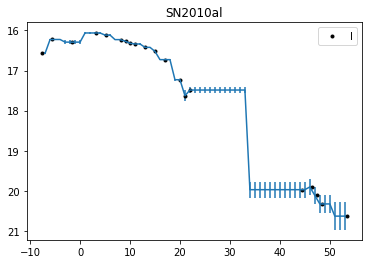

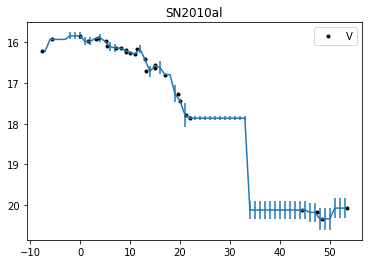

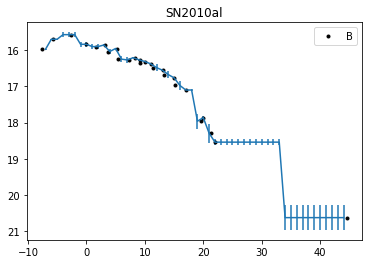

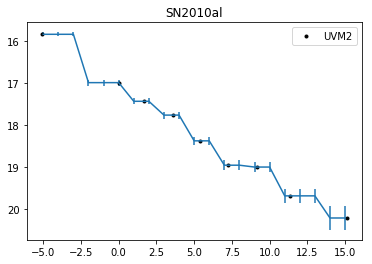

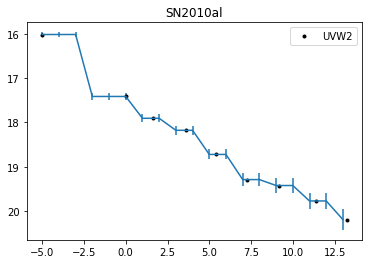

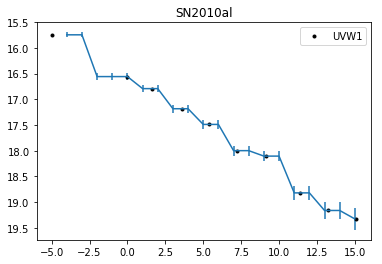

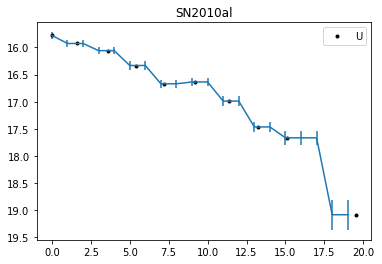

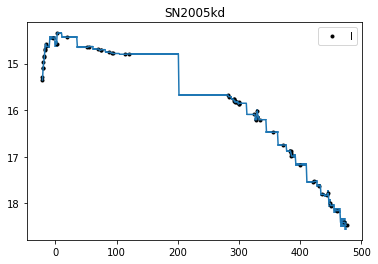

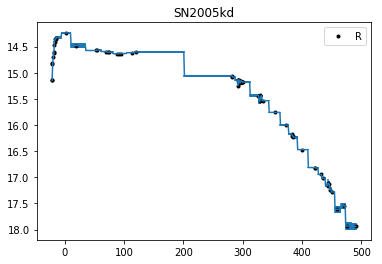

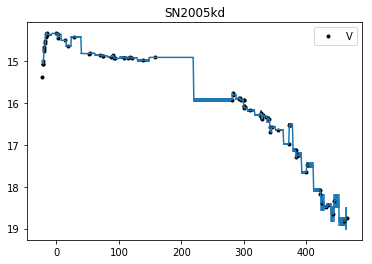

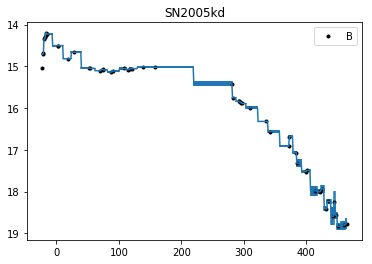

Exception UVM2 SN2005kd
Exception UVW2 SN2005kd
Exception UVW1 SN2005kd


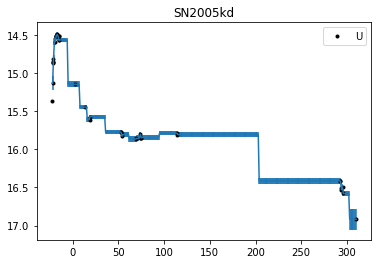

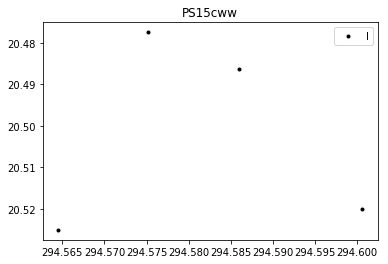

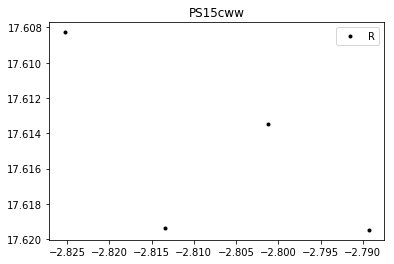

Exception B PS15cww


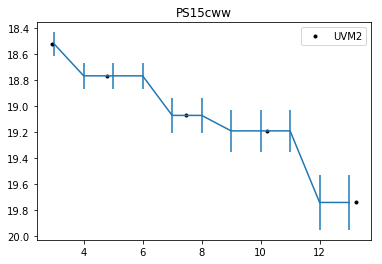

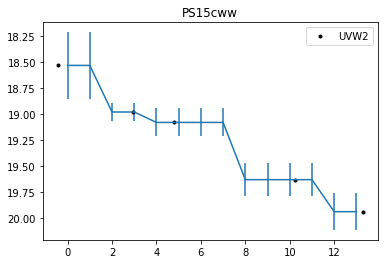

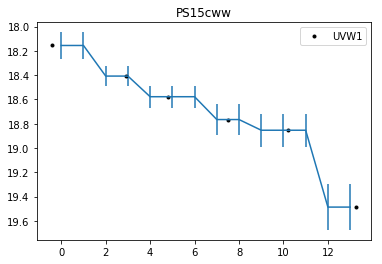

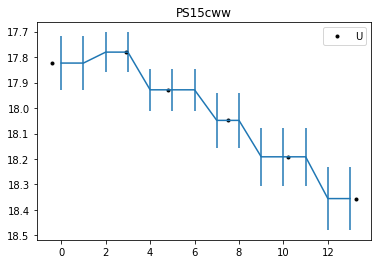

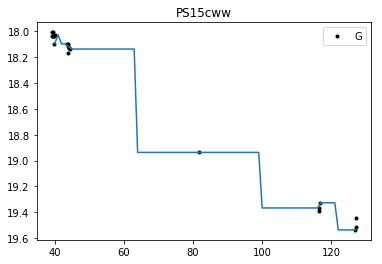

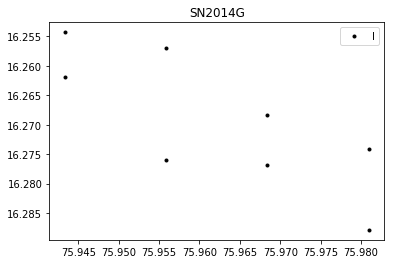

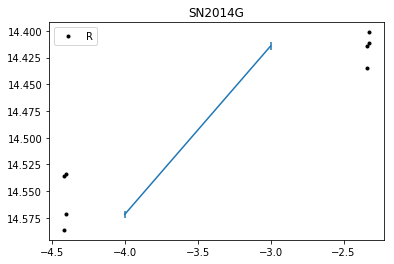

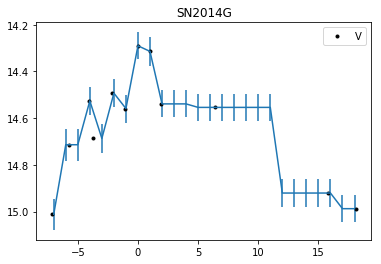

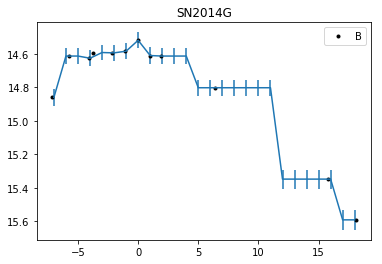

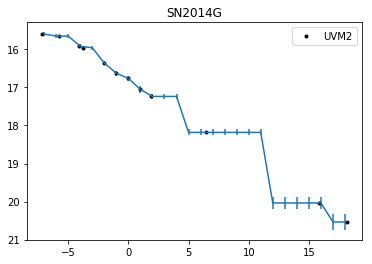

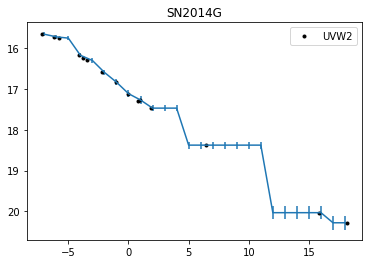

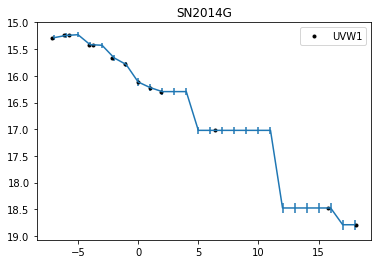

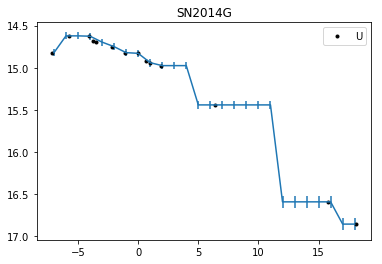

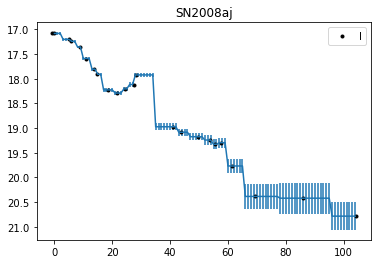

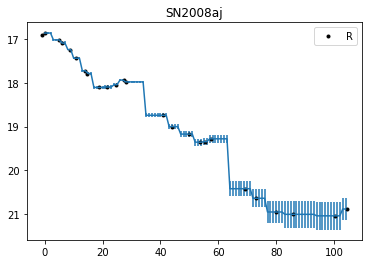

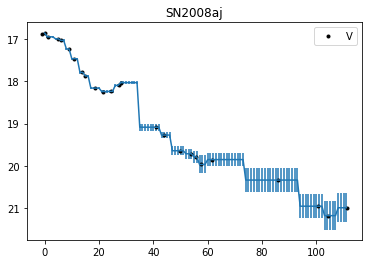

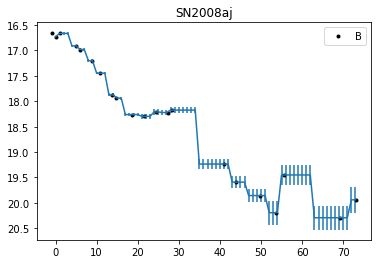

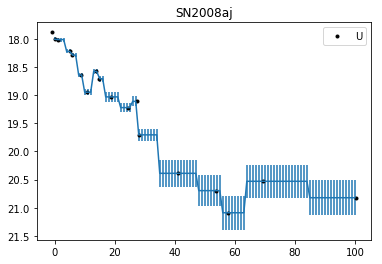

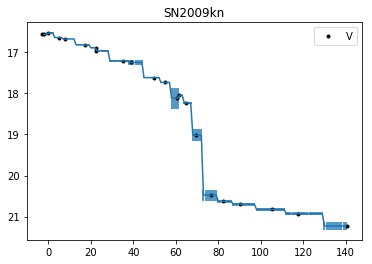

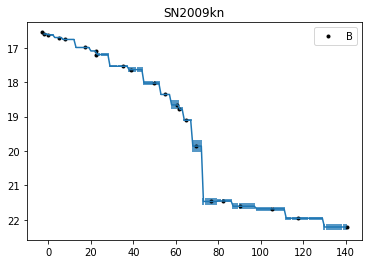

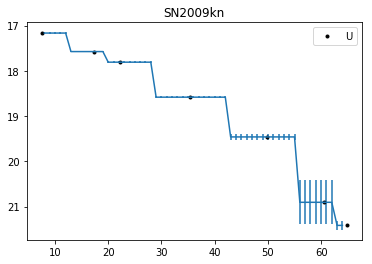

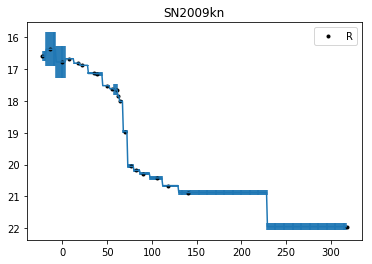

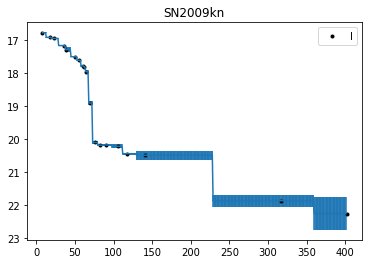

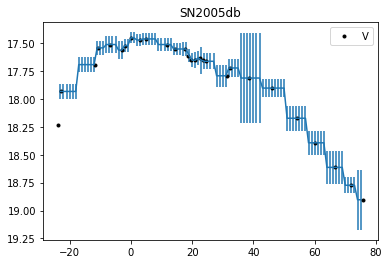

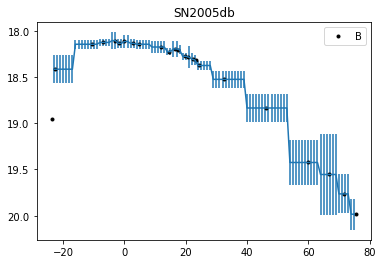

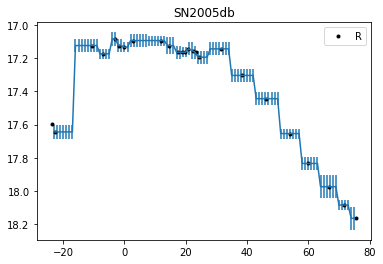

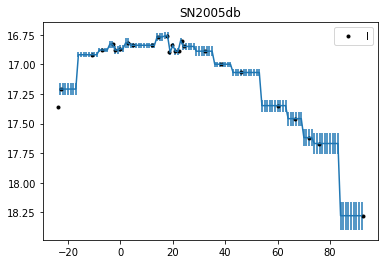

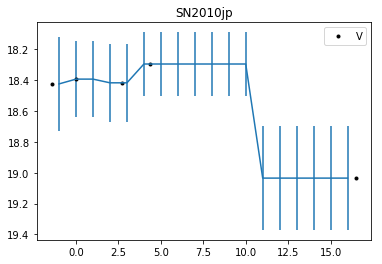

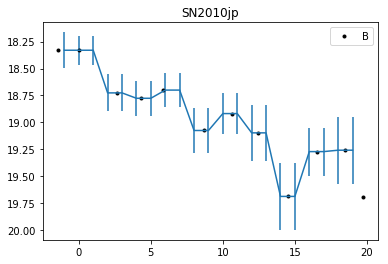

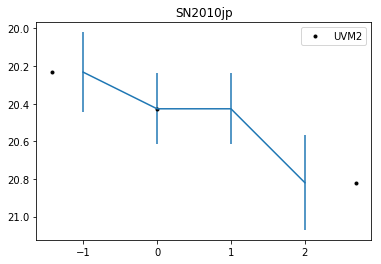

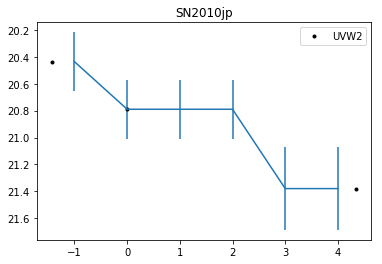

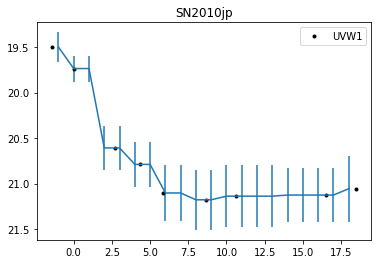

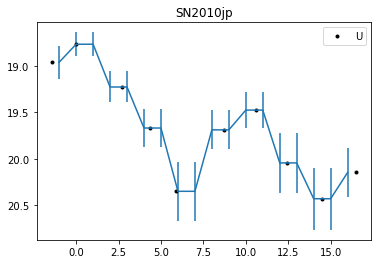

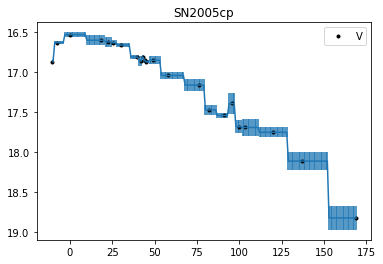

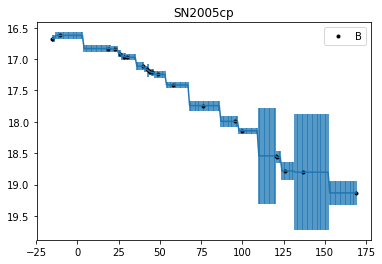

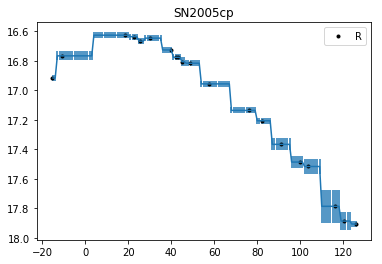

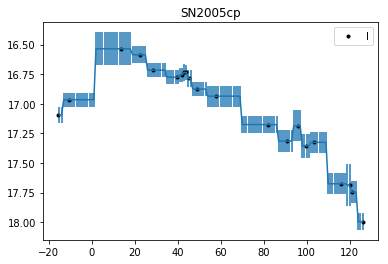

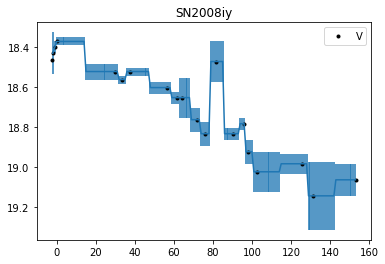

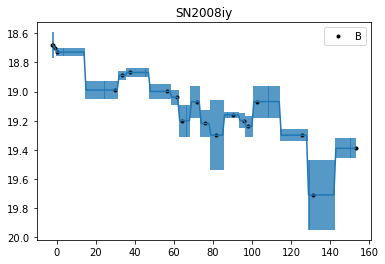

Exception UVM2 SN2008iy


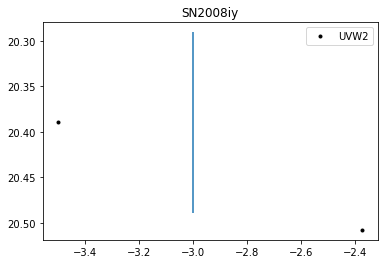

Exception UVW1 SN2008iy


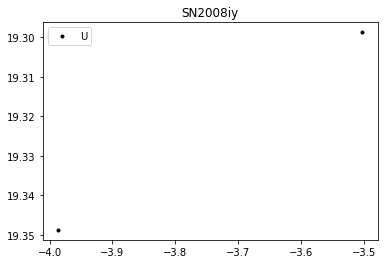

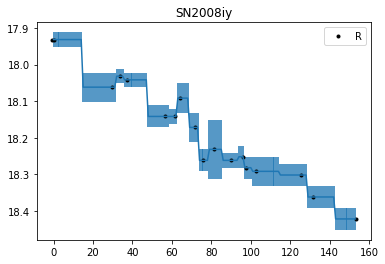

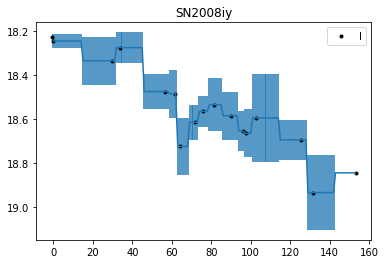

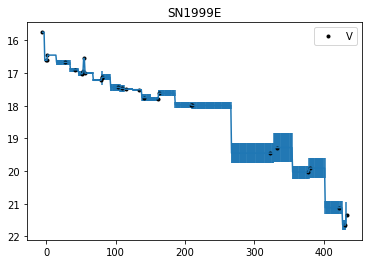

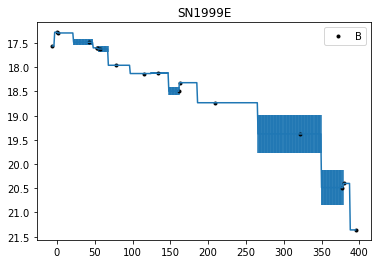

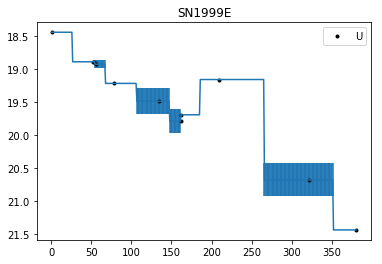

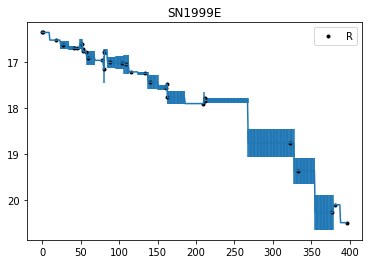

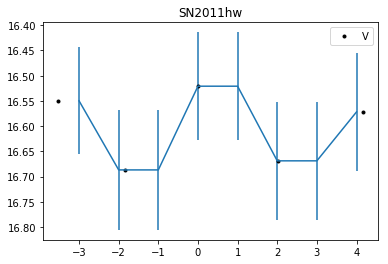

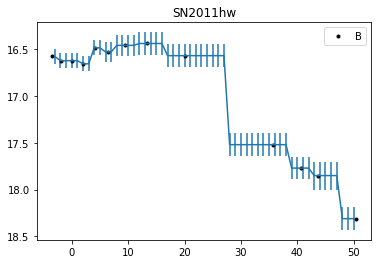

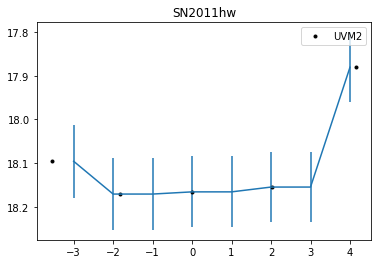

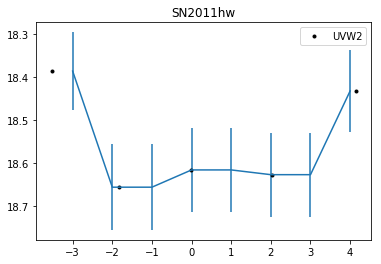

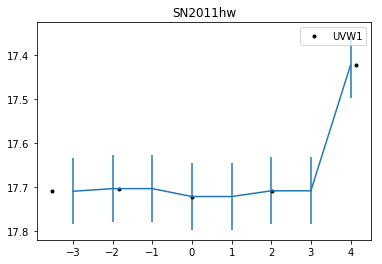

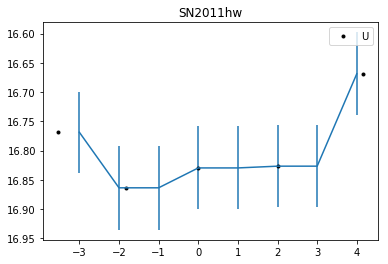

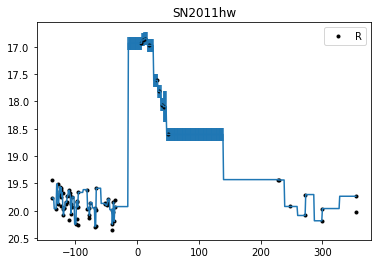

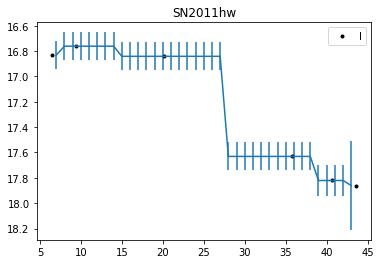

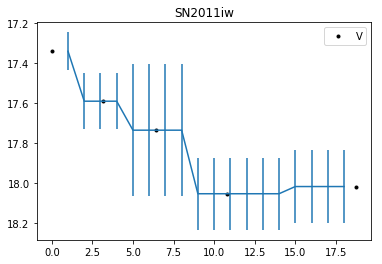

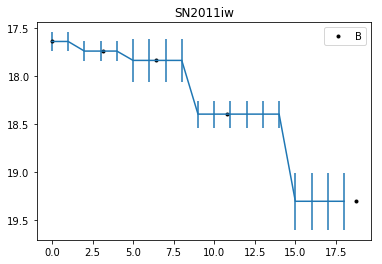

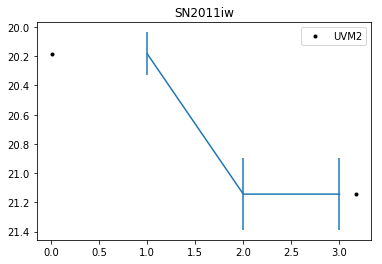

Exception UVW2 SN2011iw


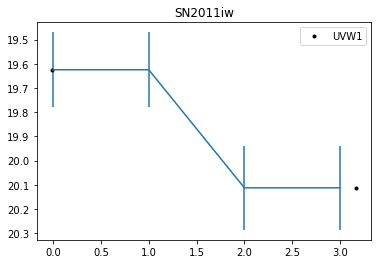

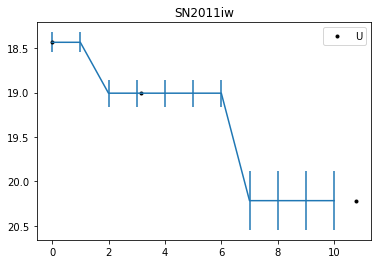

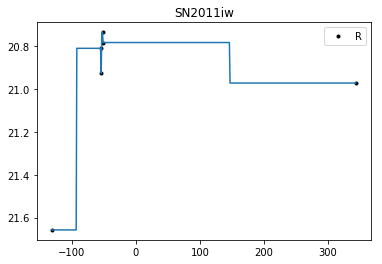

In [314]:
interpolModel = {}
for j in dat['event'].unique():
    a = dat[dat['event']==j]
    for i in a['band'].unique():
        x = a[a['band']==i]
        interpolModel[(j,i)] = {}
        try:
            interpolModel[(j,i)]['magAB'] = interp1d(x['phase'],x['magAB'],kind='nearest')
            interpolModel[(j,i)]['e_magnitude'] = interp1d(x['phase'],x['e_magnitude'],kind='nearest')
            interpolModel[(j,i)]['trange'] = (math.ceil(min(x['phase'])),math.floor(max(x['phase']))+1)

            plt.figure()
            plt.plot(x['phase'],x['magAB'],'k.',label=i)
            tgrid = np.arange(interpolModel[(j,i)]['trange'][0],interpolModel[(j,i)]['trange'][1],step=1)
            plt.errorbar(tgrid
                         ,interpolModel[(j,i)]['magAB'](tgrid)
                         ,interpolModel[(j,i)]['e_magnitude'](tgrid)
                        )
            plt.gca().invert_yaxis()
            plt.title(j)
            plt.legend()
            plt.show()
        except:
            print('Exception {0} {1}'.format(i,j))

In [327]:
temperature = {}

#########################################################################################

bandopt=['B','V','R','I']
for j in dat['event'].unique():
    temperature[(j,'opt')] = {}
    
    x = dat[dat['event']==j]
    x = x[x['band'].isin(bandopt)]
    
    tgrid = x['phase'].astype('int64').unique()
        
    for i in tgrid:
        w = []
        f = []
        ef = []
        for k in bandopt:
            try:
                x = mag2flux(interpolModel[(j,k)]['magAB'](i),wavelength[k])
                f.append(x)
                ef.append(mag2eflux(x,interpolModel[(j,k)]['e_magnitude'](i)))
                w.append(wavelength[k])
            except:
                print('Exception, cannot interpolate {0} {1} days {2}'.format(j,i,k))
                continue
        
        if len(w)<3:
            continue
        else:
            try:
                popt,pcov = curve_fit(planck,w,f,sigma=ef,p0=[10000.,1e-23],maxfev=10000)
                temperature[(j,'opt')][i] = (popt,pcov)
            except:
                print('Exception, cannot find opt solution {0} {1} days'.format(j,i))
                pass
        
# #########################################################################################

bandopt=['UVW2','UVM2','UVW1']
for j in dat['event'].unique():
    temperature[(j,'UV')] = {}
    
    x = dat[dat['event']==j]
    x = x[x['band'].isin(bandopt)]
    
    trid = x['phase'].astype('int64').unique()
        
    for i in tgrid:
        w = []
        f = []
        ef = []
        for k in bandopt:
            try:
                x = mag2flux(interpolModel[(j,k)]['magAB'](i),wavelength[k])
                f.append(x)
                ef.append(mag2eflux(x,interpolModel[(j,k)]['e_magnitude'](i)))
                w.append(wavelength[k])
            except:
                continue
        
        if len(w)<3:
            continue
        else:
            try:
                popt,pcov = curve_fit(planck,w,f,sigma=ef,p0=[10000.,1e-23],maxfev=10000)
                temperature[(j,'UV')][i] = (popt,pcov)
            except:
                print('Exception, cannot find UV solution {0} {1} days'.format(j,i))
                pass


Exception, cannot interpolate SN2010al 46 days B
Exception, cannot interpolate SN2010al 47 days B
Exception, cannot interpolate SN2010al 48 days B
Exception, cannot interpolate SN2010al 53 days B
Exception, cannot interpolate SN2005kd 470 days B
Exception, cannot interpolate SN2005kd 470 days V
Exception, cannot interpolate SN2005kd 475 days B
Exception, cannot interpolate SN2005kd 475 days V
Exception, cannot interpolate SN2005kd 491 days B
Exception, cannot interpolate SN2005kd 491 days V
Exception, cannot interpolate SN2005kd 491 days I
Exception, cannot interpolate SN2005kd -22 days R
Exception, cannot interpolate SN2005kd -22 days I
Exception, cannot interpolate PS15cww 294 days B
Exception, cannot interpolate PS15cww 294 days V
Exception, cannot interpolate PS15cww 294 days R
Exception, cannot interpolate PS15cww 294 days I
Exception, cannot interpolate PS15cww -2 days B
Exception, cannot interpolate PS15cww -2 days V
Exception, cannot interpolate PS15cww -2 days R
Exception, can

C:\Users\Kornpob\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:721: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


Exception, cannot find opt solution SN2008iy 153 days
Exception, cannot interpolate SN1999E -5 days R
Exception, cannot interpolate SN1999E -5 days I
Exception, cannot interpolate SN1999E 0 days I
Exception, cannot find opt solution SN1999E 0 days
Exception, cannot interpolate SN1999E 1 days I
Exception, cannot find opt solution SN1999E 1 days
Exception, cannot interpolate SN1999E 27 days I
Exception, cannot interpolate SN1999E 41 days I
Exception, cannot interpolate SN1999E 51 days I
Exception, cannot find opt solution SN1999E 51 days
Exception, cannot interpolate SN1999E 52 days I
Exception, cannot find opt solution SN1999E 52 days
Exception, cannot interpolate SN1999E 53 days I
Exception, cannot find opt solution SN1999E 53 days
Exception, cannot interpolate SN1999E 54 days I
Exception, cannot find opt solution SN1999E 54 days
Exception, cannot interpolate SN1999E 56 days I
Exception, cannot interpolate SN1999E 78 days I
Exception, cannot find opt solution SN1999E 78 days
Exception,

Exception, cannot interpolate SN2011iw -54 days V
Exception, cannot interpolate SN2011iw -54 days I
Exception, cannot interpolate SN2011iw -51 days B
Exception, cannot interpolate SN2011iw -51 days V
Exception, cannot interpolate SN2011iw -51 days I
Exception, cannot interpolate SN2011iw 343 days B
Exception, cannot interpolate SN2011iw 343 days V
Exception, cannot interpolate SN2011iw 343 days I


In [334]:
keepx

array([  0.,   3.,   6.,  10.,   3.,   6.,  10.,   0.,   3.,   6.,  10.,
        18.,   0.,   0.,   3.])

C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


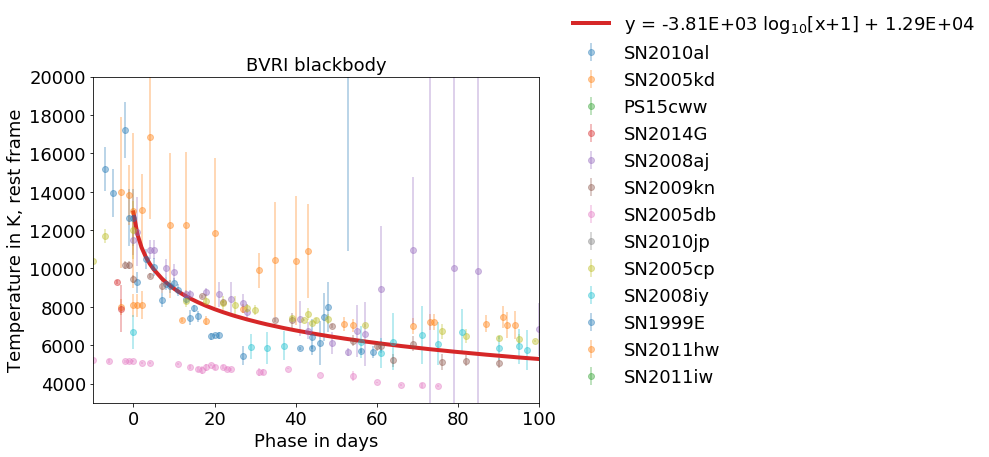

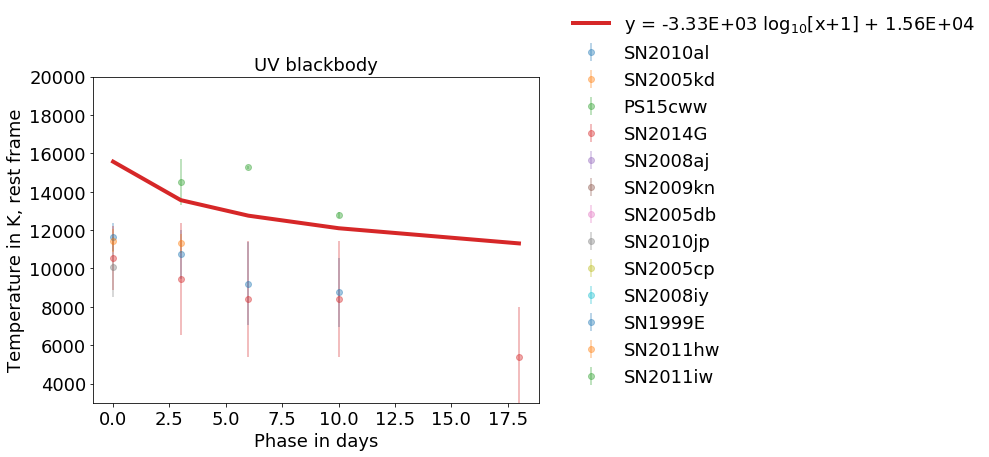

In [354]:
plt.figure(figsize=(8,6))
keepx,keepy,keepey = np.array([]),np.array([]),np.array([])
for j in dat['event'].unique():
    try:
        x = temperature[(j,'opt')]
    except:
        continue
    a = []
    b = []
    eb = []
    for i in x.keys():
        a.append(i)
        b.append(x[i][0][0])
        eb.append(np.sqrt(x[i][1][0,0]))
    a = np.array(a)
    b = np.array(b)*(1.+meta[j]['redshift'])
    eb = np.array(eb)*(1.+meta[j]['redshift'])
    plt.errorbar(a,b,eb,marker='o',linestyle='',alpha=0.4,label=j)
    
    keepx = np.concatenate((keepx,a),axis=None)
    keepy = np.concatenate((keepy,b),axis=None)
    keepey = np.concatenate((keepey,eb),axis=None)
    
# index = np.argwhere(keepx>=0).flatten()
# popt,pcov = curve_fit(expo,keepx[index],keepy[index],sigma=keepey[index],p0=[15000,-1],maxfev=10000)
# popt,pcov = curve_fit(semilog10x,keepx[index],keepy[index],sigma=keepey[index],p0=[-1,15000],maxfev=10000)
# temperature[('semilog10x','opt')] = (popt,pcov)
# tgrid = np.arange(0,max(keepx),step=1)
# l1 = plt.plot(tgrid,semilog10x(tgrid,*popt),label='y = {0:.2E} log$_{{10}}$[x+1] + {1:.2E}'.format(popt[0],popt[1]))
    
popt = temperaturemodel[('semilog10x','opt')][0]
index = np.argsort(keepx)
plt.plot(keepx[index],semilog10x(keepx[index],*popt),linewidth=4
         ,label='y = {0:.2E} log$_{{10}}$[x+1] + {1:.2E}'.format(popt[0],popt[1]))

plt.ylim(3000,20000)
plt.xlim(-10,100)
# plt.ylim(1e-5,1e-3)
# plt.xscale('log')
# plt.yscale('log')
plt.title('BVRI blackbody',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Phase in days',fontsize=18)
plt.ylabel('Temperature in K, rest frame',fontsize=18)
# plt.setp(l1, linewidth=4)
lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
plt.savefig(r'D:\Model_SED_IIn\plot_80_tempopt_predict.pdf', format='pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#####################################################################################################

plt.figure(figsize=(8,6))
keepx,keepy,keepey = np.array([]),np.array([]),np.array([])
for j in dat['event'].unique():
    x = temperature[(j,'UV')]
    a = []
    b = []
    eb = []
    for i in x.keys():
        a.append(i)
        b.append(x[i][0][0])
        eb.append(np.sqrt(x[i][1][0,0]))
    a = np.array(a)
    b = np.array(b)*(1.+meta[j]['redshift'])
    eb = np.array(eb)*(1.+meta[j]['redshift'])
    plt.errorbar(a,b,eb,marker='o',linestyle='',alpha=0.4,label=j)
    
    keepx = np.concatenate((keepx,a),axis=None)
    keepy = np.concatenate((keepy,b),axis=None)
    keepey = np.concatenate((keepey,eb),axis=None)
     
popt = temperaturemodel[('semilog10x','UV')][0]
index = np.argsort(keepx)
plt.plot(keepx[index],semilog10x(keepx[index],*popt),linewidth=4
         ,label='y = {0:.2E} log$_{{10}}$[x+1] + {1:.2E}'.format(popt[0],popt[1]))


plt.ylim(3000,20000)
plt.title('UV blackbody',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Phase in days',fontsize=18)
plt.ylabel('Temperature in K, rest frame',fontsize=18)
lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
plt.savefig(r'D:\Model_SED_IIn\plot_80_tempuv_predict.pdf', format='pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Color index prediction

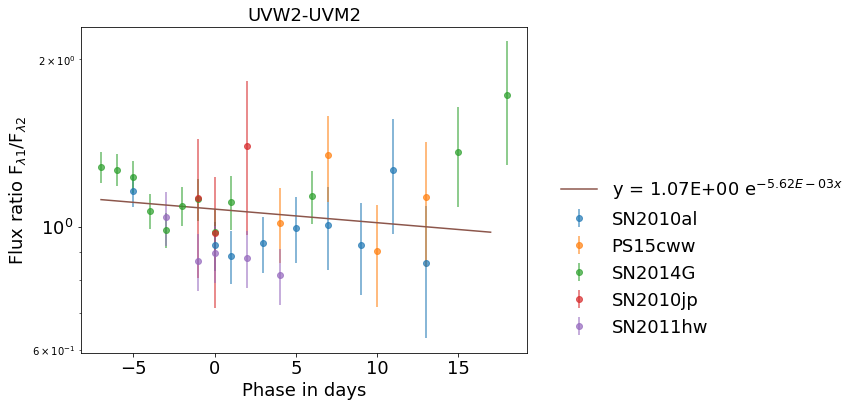

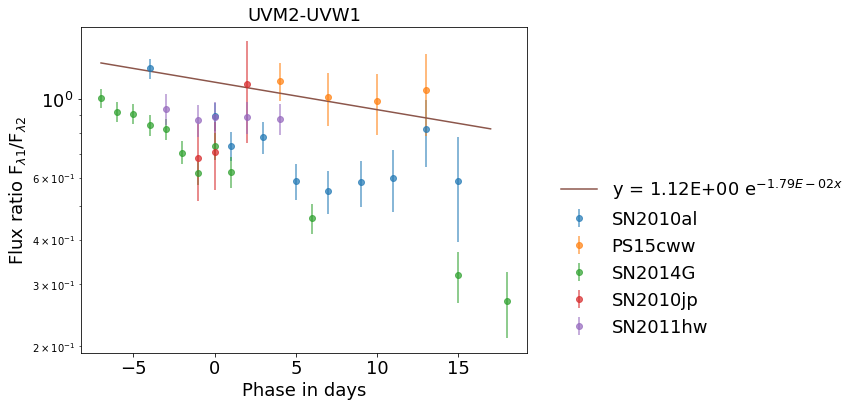

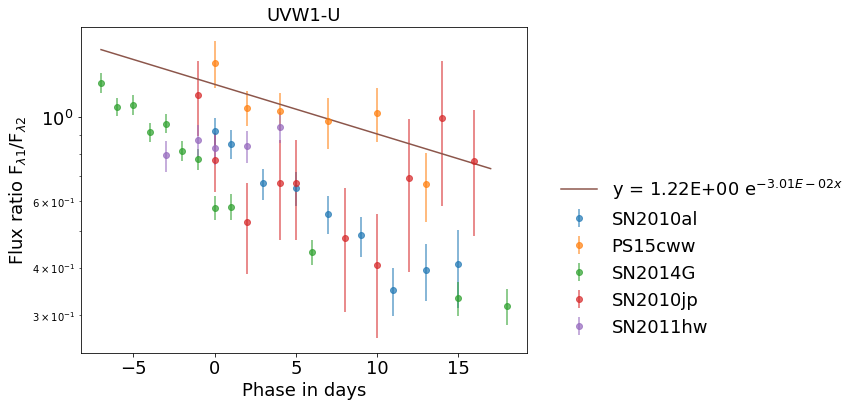

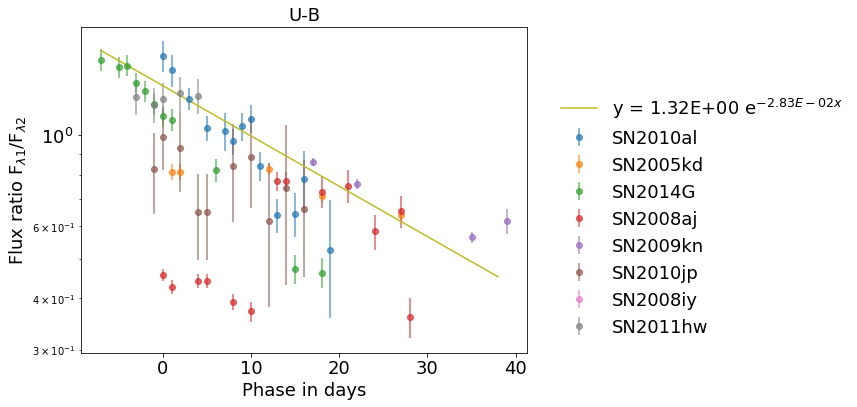

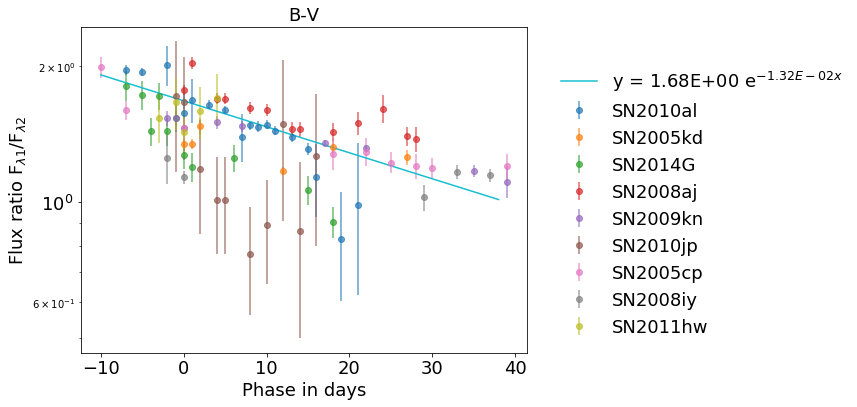

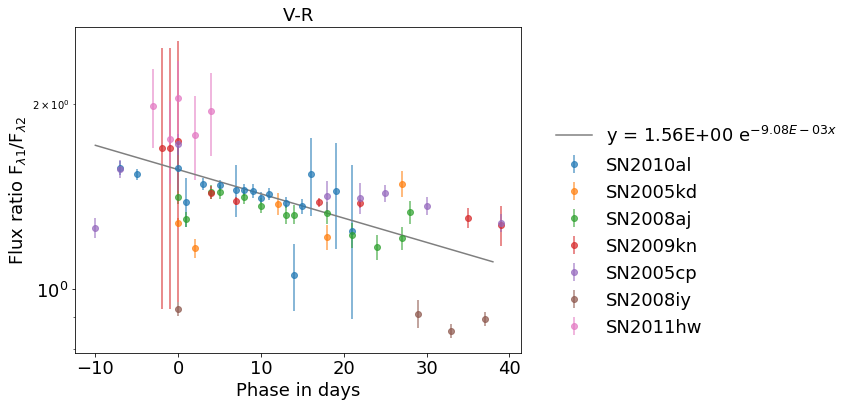

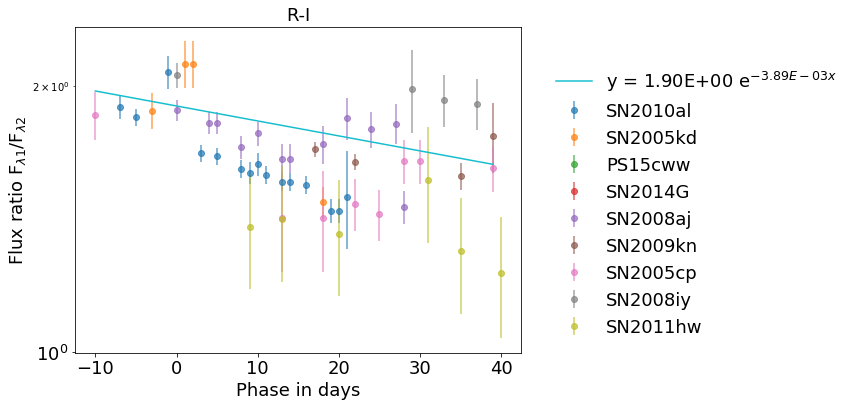

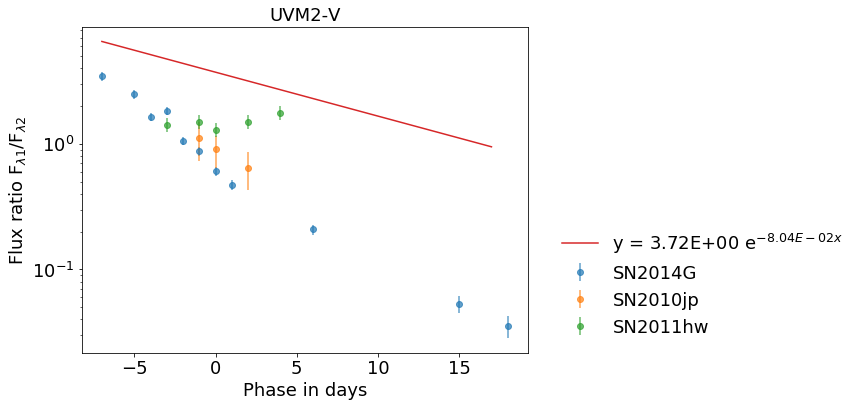

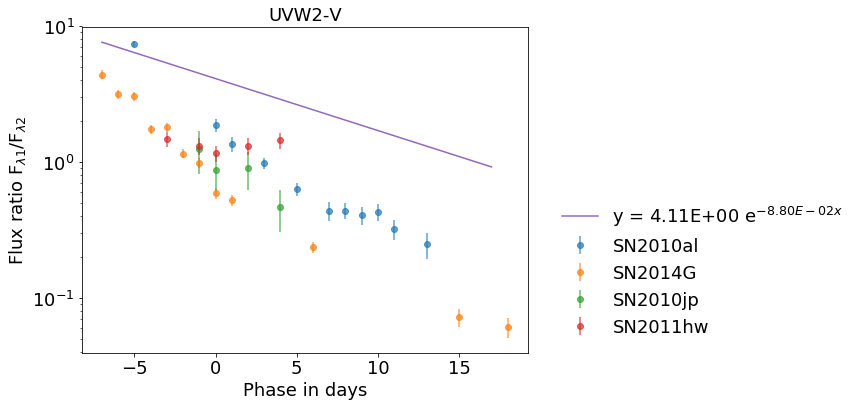

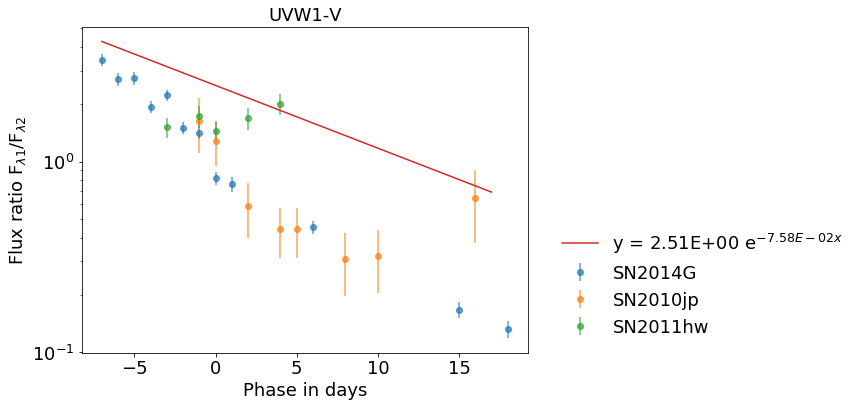

In [352]:
colorpair = np.array([('UVW2','UVM2'),('UVM2','UVW1'),('UVW1','U')
                     ,('U','B'),('B','V'),('V','R'),('R','I'),('UVM2','V'),('UVW2','V'),('UVW1','V')])
xmin = -10
xmax = 40

cccindex = {}
for i in colorpair:
    plt.figure(figsize=(8,6))
    keepx,keepy,keepey=np.array([]),np.array([]),np.array([])
    for j in dat['event'].unique():
        if j in {'SN2011iw','SN2005db','SN1999E'}:
            continue
        try:
            x = dat[dat['event']==j]
            t,tt = x[x['band']==i[0]]['phase'].astype('int64'),x[x['band']==i[1]]['phase'].astype('int64')
            tmin = max(interpolModel[(j,i[0])]['trange'][0],interpolModel[(j,i[1])]['trange'][0])
            tmax = min(interpolModel[(j,i[0])]['trange'][1],interpolModel[(j,i[1])]['trange'][1])
            tgrid = np.union1d(t,tt)
            tgrid = tgrid[tgrid>=tmin]
            tgrid = tgrid[tgrid<=tmax]
        
            f1 = mag2flux(interpolModel[(j,i[0])]['magAB'](tgrid),wavelength[i[0]])
            f2 = mag2flux(interpolModel[(j,i[1])]['magAB'](tgrid),wavelength[i[1]])
            r = f1/f2

            ef1 = mag2eflux(f1,interpolModel[(j,i[0])]['e_magnitude'](tgrid))
            ef2 = mag2eflux(f2,interpolModel[(j,i[1])]['e_magnitude'](tgrid))
            er = np.sqrt((ef1/f2)**2 + (ef2*r/f2)**2)

            index = np.intersect1d(np.argwhere(tgrid>=xmin).flatten(),np.argwhere(tgrid<=xmax).flatten())
            plt.errorbar(tgrid[index],r[index],er[index],marker='o',linestyle='',alpha=0.7,label=j)
            
            keepx = np.concatenate((keepx,tgrid[index]),axis=None)
            keepy = np.concatenate((keepy,r[index]),axis=None)
            keepey = np.concatenate((keepey,er[index]),axis=None)
        except:
#             print('Exception {} {}'.format(j,i))
            pass

    popt = colorindex[('expo',i[0],i[1])][0]
    tgrid = np.arange(min(keepx),max(keepx),step=1)
    plt.plot(tgrid,expo(tgrid,*popt),label='y = {0:.2E} e$^{{{1:.2E}x}}$'.format(popt[0],popt[1]))
    
#     try:
#         popt,pcov = curve_fit(expo,keepx,keepy,sigma=keepey,p0=[1.,-2e-2])
#     except:
#         try:
#             popt,pcov = curve_fit(expo,keepx,keepy,p0=[1.,-2e-2])
#         except:
#             continue
    
#     cccindex[('expo',i[0],i[1])] = (popt,pcov)
#     tgrid = np.arange(min(keepx),max(keepx),step=1)
#     l1 = plt.plot(tgrid,expo(tgrid,*popt),label='y = {0:.2E} e$^{{{1:.2E}x}}$'.format(popt[0],popt[1]))
    
#     plt.ylim(0.5,2)
    plt.yscale('log')
    plt.title('{0}-{1}'.format(i[0],i[1]),fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('Phase in days',fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Flux ratio F$_{\lambda1}$/F$_{\lambda2}$',fontsize=18)
    plt.setp(l1, linewidth=4)
    lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
    plt.savefig(r'D:\Model_SED_IIn\plot_80_colorindex_predict_'+i[0]+'_'+i[1]+'.eps', format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()